In [1]:
import numpy as np
#from jax import grad, jacrev, jacfwd, jit, vmap
#import jax.numpy as jnp
#import jax.scipy as jscp

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons
from sklearn.svm import SVC

import seaborn as sns
import scipy as scp

#import jax
#jax.config.update("jax_platform_name", "cpu")

#import matplotlib
#matplotlib.use("pgf")
#matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
#    'font.family': 'serif',
#    'text.usetex': True,
#    'pgf.rcfonts': False,
#})


np.random.seed(32)

In [2]:
Phi_g = lambda v: scp.stats.norm.cdf(v, loc=0, scale=1)
phi_g = lambda v: scp.stats.norm.pdf(v, loc=0, scale=1)

In [3]:
def psi_g(alpha, sigma):
    return Phi_g((1- alpha)/sigma) * (1 - alpha) + phi_g((1- alpha)/sigma) * sigma

In [4]:
Phi_m = lambda v: (1 + v/np.sqrt(1 + v**2))/2
phi_m = lambda v: 1/(2 * np.sqrt(1 + v**2))

The two terms which make up the smooth hinge loss are,
\begin{align*}
    \Phi_m(v) = (1 + v/\sqrt{(1 + v^2)})/2 \\
    \phi_m(v) = 1/(2 \cdot \sqrt{(1 + v^2)}).
\end{align*}

Where the final form is,
\begin{align*}
    \psi_m(v) = \Phi_m(v/\sigma) \cdot v + \phi_m(v/\sigma) \cdot \sigma,
\end{align*}
for $v = 1 - \alpha$ and we use $\alpha = yXw$ for the SVM.

Now, the derivative for the individual terms wrt $v$ is,

\begin{align*}
    \frac{\partial \Phi_m(v)}{\partial v} = \frac{1}{2(v^2+1)^{\frac{3}{2}}} \\
    \frac{\partial \phi_m(v)}{\partial v} = -\frac{v}{2 (v^2 + 1)^{\frac{3}{2}}}
\end{align*}

$(1 + (v/\sigma)/(\sqrt{1+(v/\sigma)^2}))*v/2 + 1/(2\sqrt{(1+(v/\sigma)^2})) * \sigma$
$(1 + (1-\alpha/\sigma)/(\sqrt{1+(1-\alpha/\sigma)^2}))*1-\alpha/2 + 1/(2\sqrt{(1+(1-\alpha/\sigma)^2})) * \sigma$
$(1 + (1-yXw/\sigma)/(\sqrt{1+(1-yXw/\sigma)^2}))*1-yXw/2 + 1/(2\sqrt{(1+(1-yXw/\sigma)^2})) * \sigma$

So, the derivative of the smooth hinge loss for $v = 1 - \alpha$ is,
\begin{align*}
    \frac{\partial \psi_m(v)}{\partial v} &= \left(\frac{\partial \Phi_m(v)}{\partial v} \cdot v + \Phi_m(v) \cdot \frac{\partial v}{\partial \alpha} \right) + \frac{\partial \phi_m(v)}{\partial v} \cdot \sigma \\
    &= \frac{1}{2(v^2+1)^{\frac{3}{2}}} \cdot v - \frac{1}{2}\left(1 + \frac{v}{\sqrt{(1 + v^2)}}\right) -\frac{v}{2 (v^2 + 1)^{\frac{3}{2}}} \cdot \sigma \\
    &= \frac{v(1 - \sigma)}{2(v^2+1)^{\frac{3}{2}}} - \frac{1}{2} - \frac{v}{2(1 + v^2)^{\frac{1}{2}}} \\
    &= \frac{v(1 - \sigma - (1 + v^2))}{2(v^2+1)^{\frac{3}{2}}} - \frac{1}{2}.
\end{align*}

## Gradient descent on derivative by hand
$$
    = -\frac{1}{2} y_i x_i - \frac{1}{2} \left[(1 - y_i w^t x_i)^2 + \sigma^2\right]^{-1/2} (1 - y_i w^T x_i) (-y_i x_i)
$$

In [5]:
def nabla_psi(alpha, sigma):
    v = 1 - alpha
    return (v * (1 - sigma + (1 + v**2)))/(2 * np.sqrt((v**2 + 1))**3) - 1/2

In [6]:
def psi_m(alpha, sigma):
    return Phi_m((1 - alpha)/sigma) * (1 - alpha) + phi_m((1 - alpha)/sigma) * sigma

In [7]:
def L(w, X, y, sigma, lbd=0.3):
    return 1/2 * lbd *  np.linalg.norm(w, ord=2)**2 + np.mean(psi_m(y * (X @ w), sigma))

In [8]:
def L_alt(w, X, y, sigma, lbd=0.3):
    return np.mean(psi_m(y * (X @ w), sigma))

In [9]:
#X, y = make_blobs(n_samples=200, n_features=2, centers=[[-1,-1], [1,1]], cluster_std=1.5)
X, y = make_blobs(n_samples=150, n_features=2, centers=[[-0.15,0], [0.15,0]], cluster_std=0.1)
#X, y = make_blobs(n_samples=250, n_features=2, centers=[[0,-1], [0,1]])
#X, y = make_moons(n_samples=100, noise=0.2, random_state=13)
y[np.where(y == 0)] = -1

In [10]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target
y[np.where(y == 0)] = -1
print(X)
print(y)

[[1.799e+01 1.038e+01 1.228e+02 ... 2.654e-01 4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 ... 1.860e-01 2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 ... 2.430e-01 3.613e-01 8.758e-02]
 ...
 [1.660e+01 2.808e+01 1.083e+02 ... 1.418e-01 2.218e-01 7.820e-02]
 [2.060e+01 2.933e+01 1.401e+02 ... 2.650e-01 4.087e-01 1.240e-01]
 [7.760e+00 2.454e+01 4.792e+01 ... 0.000e+00 2.871e-01 7.039e-02]]
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
  1  1  1  1  1 -1 -1  1 -1 -1  1  1  1  1 -1  1 -1 -1  1  1  1  1 -1  1
 -1 -1  1 -1  1 -1 -1  1  1  1 -1 -1  1 -1 -1 -1  1  1  1 -1  1  1 -1 -1
  1  1  1 -1 -1  1  1  1  1 -1  1  1 -1  1  1  1  1  1  1  1  1 -1 -1 -1
  1 -1 -1  1  1  1 -1 -1  1 -1  1 -1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1 -1 -1  1 -1  1  1 -1
 -1  1  1 -1 -1  1  1  1  1 -1  1  1 -1 -1 -1  1 -1  1 -1  1  1  1 -1  1
  1 -1 -

In [11]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [12]:
clf = SVC(kernel='linear').fit(X, y)
print(clf.coef_)
print(clf.intercept_)

[[-0.32157975 -0.0963414  -0.29618472 -0.27044914  0.0145657   0.61925944
  -0.75749079 -0.90968508 -0.07847361  0.34800574 -0.84095245  0.30550603
  -0.23541953 -0.89135374 -0.35509455  0.39115374  0.37739417 -0.46041889
   0.10093298  0.88583541 -0.59013908 -0.97190388 -0.33349947 -0.71227359
  -0.42708268  0.1721726  -1.03818882 -0.09378355 -0.44679874 -0.85526809]]
[0.04438971]


In [13]:
#X = np.c_[X, np.ones(X.shape[0])]

In [14]:
print(X.shape)
print(y.shape)

n = X.shape[0]
p = X.shape[1]

(569, 30)
(569,)


In [15]:
def nabla_psi_X(X, y, w, sigma):
    #numerator = y @ X * (sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3 + y @ X * w - sigma + 2)
    numerator = (sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3 + y @ X * w - sigma + 2)
    denom = 2 * sigma * np.sqrt((1 - y @ X * w/sigma)**2 + 1)**3
    return -numerator/denom

In [16]:
def nabla_fgd(X, y, w, sigma, lbd):
    return (lbd * w - 1/n * y @ X * Phi_m((1 - y @ X * w)/sigma))

def nabla_fgd_single(X, y, w, sigma, lbd):
    return (lbd * w - 1/n * y * X * Phi_m((1 - y * X * w)/sigma))

In [17]:
def hess_fgd(X, y, w, sigma, lbd):
    d = phi_m((1 - y @ X * w)/sigma)
    D = np.eye(p)
    for i in range(p):
        D[i, i] = d[i]
        
    hess = lbd * np.eye(p) + 1/n * (X @ D).T @ X
    return hess

In [18]:
def hess_fgd_single(X, y, w, sigma, lbd):
    d = phi_m((1 - y * X * w)/sigma)
    D = np.eye(p)
    for i in range(p):
        D[i, i] = d[i]
        
    hess = lbd * np.eye(p) + 1/n * (X @ D).T @ X
    return hess

In [19]:
# gradient testing
w_og = np.zeros(p)
n_iter = 1250
eta = 0.3
sigma = 0.01
lbd = 0.85

alpha_t = 0.5/n

w_true_og = np.zeros((n, p))
w_cv_og = np.zeros((n, p))

thresh = 1e-8

for t in range(n_iter):
    f_grad = nabla_fgd(X, y, w_og, sigma, lbd)
    f_hess = hess_fgd(X, y, w_og, sigma, lbd)
    
    if np.linalg.norm(f_grad) < thresh:
        print(f"stopping early at iteration {t}")
        break
    
    hess_per_sample = np.zeros((n, p, p))
    for i in range(n):
        hess_per_sample[i] = hess_fgd_single(X[i], y[i], w_og, sigma, lbd)
        
    grad_per_sample = np.zeros((n, p))
    for i in range(n):
        grad_per_sample[i] = nabla_fgd_single(X[i], y[i], w_og, sigma, lbd)
        
    hess_minus_i = f_hess - hess_per_sample
    grad_minus_i = f_grad - grad_per_sample
    
    #print(f_hess)
    w_cv_og = w_cv_og - alpha_t * grad_minus_i - alpha_t * np.vectorize(np.matmul, signature='(p, p),(p)->(p)')(hess_minus_i, (w_cv_og - w_og))
    #w_cv_og /= np.asarray([np.linalg.norm(w_cv_og, axis=1)] * p).T
    
    for i in range(n):
        X_temp = np.delete(X, (i), axis=0)
        y_temp = np.delete(y, (i), axis=0)
        w_true_og[i] = w_true_og[i] - eta * nabla_fgd(X_temp, y_temp, w_true_og[i], sigma, lbd)
        #w_true_og[i] = w_true_og[i] - eta * (lbd * w_true_og[i] - y @ X * Phi_m((1 - y_temp @ X_temp * w_true_og[i])/sigma))
        
    #w_true_og /= np.asarray([np.linalg.norm(w_true_og, axis=1)] * p).T
    w_og = w_og - eta * f_grad
    #w_og /= np.linalg.norm(w_og)
    print(f"{w_og} | IACV: {np.mean(np.linalg.norm(w_true_og - w_cv_og, 2, axis=1))} | baseline: {np.mean(np.linalg.norm(w_true_og - w_og, 2, axis=1))}")


#w_og /= np.linalg.norm(w_og)
print(np.mean(w_true_og, axis=0))
print(np.mean(w_cv_og, axis=0))
#w_og = w_og/np.linalg.norm(w_og)
#print(w_og/np.linalg.norm(w_og))

[-0.21177271 -0.12044038 -0.21542985 -0.20566789 -0.10401404 -0.17304742
 -0.20200578 -0.22528656 -0.09587375  0.00372404 -0.16451887  0.0024087
 -0.16132989 -0.15903681  0.01944056 -0.08499564 -0.07360403 -0.11836829
  0.00189188 -0.02261888 -0.22524013 -0.13254215 -0.22711421 -0.21287403
 -0.12226201 -0.17144166 -0.19134518 -0.23020419 -0.1207621  -0.09395152] | IACV: 0.8434352034801287 | baseline: 0.0026026344342846585
[-0.15777067 -0.08972809 -0.16049524 -0.15322258 -0.07749047 -0.12892033
 -0.15049431 -0.16783849 -0.07142596  0.00649844 -0.12256656  0.00420318
 -0.12019077 -0.11848243  0.0339182  -0.06332177 -0.05483502 -0.08818438
  0.00330134 -0.03887612 -0.1678039  -0.0987439  -0.16920008 -0.15859116
 -0.0910852  -0.12772403 -0.14255216 -0.17150212 -0.08996777 -0.06999389] | IACV: 0.6293462596047272 | baseline: 0.004702091567896368
[-0.11753915 -0.06684744 -0.11956896 -0.11415082 -0.05773041 -0.09604565
 -0.11211826 -0.12503968 -0.05321235  0.00856537 -0.09131209  0.00554007
 -

[-0.04945266 -0.01567624 -0.11931459 -0.04714694 -0.01017043 -0.03983742
 -0.06140048 -0.09277939 -0.00702151  0.0145738  -0.03811564  0.00942634
 -0.03454466 -0.04950385  0.02150265 -0.0706476  -0.01872875 -0.02049386
  0.00740381 -0.02864457 -0.09275834 -0.01594604 -0.09351267 -0.01518525
 -0.01590717 -0.03959607 -0.0591336  -0.09433034 -0.01571869 -0.00689919] | IACV: 0.3284815078684667 | baseline: 0.16102008813822746
[-0.03684225 -0.01167925 -0.08888937 -0.03512448 -0.00757954 -0.02967891
 -0.04574337 -0.06912065 -0.00526227  0.0145815  -0.02839619  0.00943131
 -0.02573582 -0.03688039  0.03544921 -0.05263248 -0.01395362 -0.01526815
  0.00740772 -0.02135098 -0.06910497 -0.01188017 -0.06966695 -0.01131322
 -0.01185126 -0.0294991  -0.04405455 -0.07027611 -0.01171087 -0.00518445] | IACV: 0.2586321751327151 | baseline: 0.13575540355156418
[-0.0274475  -0.00870212 -0.06622258 -0.02616777 -0.00565735 -0.02211084
 -0.03407883 -0.05149489 -0.09855509  0.01458723 -0.02115523  0.00943502
 -0.

[-0.00247244 -0.09171218 -0.06631894 -0.01123754 -0.03300725 -0.00913648
 -0.0190661  -0.03834579 -0.0125869   0.0146039  -0.00875124  0.0094458
 -0.05019527 -0.01308871  0.02150176 -0.01126606 -0.01780941 -0.01137678
  0.0074191  -0.03844628 -0.03833629 -0.06311641 -0.0386692  -0.00464044
 -0.09303431 -0.00908136 -0.0182242  -0.03908301 -0.09194622 -0.01241003] | IACV: 0.27832415094040713 | baseline: 0.17092280337163443
[-0.16781721 -0.06832559 -0.04940762 -0.00837242 -0.02459049 -0.00680776
 -0.01420437 -0.02856764 -0.00937868  0.01460392 -0.00652105  0.00944582
 -0.03739549 -0.00975155  0.03544855 -0.00839641 -0.01326884 -0.00847693
  0.00741911 -0.02864382 -0.02856056 -0.04702174 -0.02880858 -0.0034641
 -0.06931057 -0.00676674 -0.01357718 -0.02911686 -0.06849994 -0.00924707] | IACV: 0.2250630342556888 | baseline: 0.18223718628450009
[-0.12502383 -0.05090258 -0.03680869 -0.00623845 -0.01832009 -0.00507462
 -0.01058252 -0.02128293 -0.00699193  0.01460394 -0.00486202  0.00944583
 -0.0

[-0.00973594 -0.0116828  -0.03678114 -0.01936013 -0.10714783 -0.1734779
 -0.00585177 -0.01585481 -0.02266423  0.01460398 -0.16613665  0.00944586
 -0.01143224 -0.00362201  0.02150176 -0.00630062 -0.03222334 -0.01062963
  0.00741915 -0.02135042 -0.01585079 -0.00953877 -0.0159896  -0.01949251
 -0.01185116 -0.17241998 -0.00561661 -0.01615487 -0.0117126  -0.02235792] | IACV: 0.35422413540015335 | baseline: 0.1332416515314252
[-0.0072539  -0.00870477 -0.02740198 -0.01442342 -0.07982514 -0.12924103
 -0.00436285 -0.011812   -0.01688509  0.01460398 -0.12377181  0.00944586
 -0.00851766 -0.00315836  0.03544855 -0.01132208 -0.02400654 -0.00792061
  0.00741915 -0.03844628 -0.01180901 -0.00710808 -0.01191242 -0.01452203
 -0.00883012 -0.12845289 -0.00418881 -0.01203553 -0.00872695 -0.01665691] | IACV: 0.27832321452560305 | baseline: 0.1228687364663962
[-0.0054056  -0.00648813 -0.02041452 -0.01074569 -0.05946974 -0.09628457
 -0.00326151 -0.00880029 -0.01257995  0.01460398 -0.09221     0.00944586
 -0.0

[-0.00344111 -0.06832559 -0.02042461 -0.00533176 -0.0101693  -0.03981359
 -0.20032161 -0.00655689 -0.04083165  0.01460398 -0.03812828  0.00944586
 -0.0038339  -0.08924842  0.02150176 -0.02740026 -0.05794263 -0.03730073
  0.00741915 -0.02864382 -0.00655522 -0.03094121 -0.00661265 -0.02093996
 -0.06931057 -0.03957035 -0.1920522  -0.00668139 -0.06849994 -0.04028242] | IACV: 0.38633202539652806 | baseline: 0.17960824302281167
[-0.00259985 -0.05090258 -0.01521643 -0.00397657 -0.0075787  -0.02966115
 -0.1492396  -0.00488662 -0.03041964  0.01460398 -0.0284056   0.00944586
 -0.00299043 -0.06649008  0.03544855 -0.02041337 -0.0431673  -0.0277891
  0.00741915 -0.02135042 -0.00488537 -0.02305128 -0.00492808 -0.01560037
 -0.05163639 -0.02947994 -0.14307889 -0.0049792  -0.05103247 -0.03001046] | IACV: 0.3041623508923014 | baseline: 0.1592710145961228
[-0.00453699 -0.03792245 -0.01133644 -0.00297946 -0.00565673 -0.02209762
 -0.1111835  -0.00364529 -0.02266275  0.01460398 -0.02116224  0.00944586
 -0.1

[-0.01112813 -0.00870477 -0.01133308 -0.14395797 -0.03300725 -0.00913789
 -0.06174896 -0.00273384 -0.07356659  0.01460398 -0.0087513   0.00944586
 -0.06689222 -0.00367539  0.02150176 -0.01262212 -0.03215794 -0.00476325
  0.00741915 -0.03844628 -0.0027332  -0.09966653 -0.00275524 -0.01505069
 -0.00883012 -0.00908212 -0.05916222 -0.00278155 -0.00872695 -0.07257758] | IACV: 0.20850163506912406 | baseline: 0.1858879849363202
[-0.0082909  -0.00648813 -0.00844356 -0.10724869 -0.02459049 -0.00680881
 -0.04600298 -0.00223531 -0.05480713  0.01460398 -0.00652109  0.00944586
 -0.04983472 -0.00307272  0.03544855 -0.00940546 -0.02395782 -0.00415361
  0.00741915 -0.02864382 -0.00223601 -0.07425157 -0.00221489 -0.01121297
 -0.00658122 -0.0067673  -0.04407587 -0.00219712 -0.00650461 -0.05407031] | IACV: 0.18150594797849542 | baseline: 0.1545867391000912
[-0.00617769 -0.00484661 -0.00629135 -0.07990028 -0.01832009 -0.0050754
 -0.03427224 -0.22425683 -0.04083134  0.01460398 -0.00486205  0.00944586
 -0.0

[-0.02006246 -0.05090258 -0.00629254 -0.04708271 -0.10714783 -0.17347964
 -0.01901556 -0.16707133 -0.00523843  0.01460398 -0.16613665  0.00944586
 -0.01497217 -0.08702249  0.02150176 -0.02122918 -0.01795503 -0.02772294
  0.00741915 -0.02135042 -0.1670287  -0.01030847 -0.1684937  -0.11806713
 -0.05163639 -0.17242022 -0.01822521 -0.17024507 -0.05103247 -0.00518139] | IACV: 0.48310823657107094 | baseline: 0.16643378599387565
[-0.01494664 -0.03792245 -0.00469013 -0.03507663 -0.07982514 -0.12924234
 -0.01416672 -0.12446814 -0.098747    0.01460398 -0.12377181  0.00944586
 -0.01115458 -0.06483176  0.03544855 -0.0158161  -0.01337731 -0.0206537
  0.00741915 -0.03844628 -0.12443638 -0.00768112 -0.12552781 -0.08796002
 -0.03846913 -0.12845306 -0.01357793 -0.12683258 -0.03801922 -0.09741956] | IACV: 0.3925437293559135 | baseline: 0.1438244096739156
[-0.01113546 -0.02825227 -0.00350056 -0.02613212 -0.05946974 -0.09628554
 -0.01055446 -0.09272877 -0.07356653  0.01460398 -0.09221     0.00944586
 -0.0

[-0.03969318 -0.00648813 -0.00350015 -0.01167377 -0.0101693  -0.03981349
 -0.00586072 -0.06908294 -0.00937282  0.01460398 -0.03812828  0.00944586
 -0.00477052 -0.03688962  0.02150176 -0.0656497  -0.01789586 -0.00416696
  0.00741915 -0.02864382 -0.06906531 -0.04994135 -0.06967108 -0.07783083
 -0.00658122 -0.03957035 -0.00561665 -0.07039526 -0.00650461 -0.00924706] | IACV: 0.20202296202067901 | baseline: 0.14144654830014503
[-0.02957144 -0.00484661 -0.0026367  -0.00869736 -0.0075787  -0.02966108
 -0.00436949 -0.05146679 -0.00698758  0.01460398 -0.0284056   0.00944586
 -0.00357311 -0.0274828   0.03544855 -0.04890905 -0.01333324 -0.12077632
  0.00741915 -0.02135042 -0.05145366 -0.03720633 -0.05190496 -0.05798398
 -0.00491405 -0.02947994 -0.00418884 -0.05244448 -0.00485851 -0.00689465] | IACV: 0.17751474860612376 | baseline: 0.16206771068942052
[-0.02203077 -0.00387122 -0.00285273 -0.00648043 -0.00565673 -0.02209756
 -0.00326638 -0.03834277 -0.00523843  0.01460398 -0.02116224  0.00944586
 -

[-0.01487796 -0.03792245 -0.00285121 -0.00765617 -0.03300725 -0.0091379
 -0.20040866 -0.02856539 -0.01688385  0.01460398 -0.0087513   0.00944586
 -0.08741548 -0.00679947  0.02150176 -0.02040959 -0.02407874 -0.02064954
  0.00741915 -0.03844628 -0.0285581  -0.00710371 -0.02880858 -0.02691961
 -0.03846913 -0.00908212 -0.19205221 -0.02910803 -0.03801922 -0.01665691] | IACV: 0.35199821214595556 | baseline: 0.200036398743497
[-0.01108429 -0.02825227 -0.00232137 -0.00570515 -0.02459049 -0.00680882
 -0.14930446 -0.02128126 -0.01257902  0.01460398 -0.00652109  0.00944586
 -0.06512454 -0.0050692   0.03544855 -0.01520555 -0.01793899 -0.01538413
  0.00741915 -0.02864382 -0.02127583 -0.00529763 -0.02146244 -0.02005516
 -0.02865955 -0.0067673  -0.1430789  -0.02168552 -0.02832437 -0.01241001] | IACV: 0.276434061755059 | baseline: 0.1697927164986338
[-0.00825824 -0.02104804 -0.21518738 -0.00425376 -0.01832009 -0.00507541
 -0.11123182 -0.01585463 -0.00937282  0.01460398 -0.00486205  0.00944586
 -0.0485

[-0.01494198 -0.00484661 -0.21519374 -0.00253942 -0.10714783 -0.17347965
 -0.06173469 -0.01181186 -0.03041937  0.01460398 -0.16613665  0.00944586
 -0.02787619 -0.02054295  0.02150176 -0.01734962 -0.02391421 -0.12077008
  0.00741915 -0.02135042 -0.01180885 -0.02290172 -0.01191242 -0.02002786
 -0.00491405 -0.17242022 -0.05916222 -0.01203622 -0.00485851 -0.03001046] | IACV: 0.3874642543608199 | baseline: 0.18314625536258627
[-0.01113199 -0.00387122 -0.16031934 -0.17512485 -0.07982514 -0.12924234
 -0.04599235 -0.00880018 -0.02266255  0.01460398 -0.12377181  0.00944586
 -0.02076783 -0.01530464  0.03544855 -0.01292612 -0.01781642 -0.08997371
  0.00741915 -0.03844628 -0.00879794 -0.01706193 -0.00887508 -0.01492086
 -0.00381733 -0.12845306 -0.04407587 -0.0089673  -0.00385529 -0.02235792] | IACV: 0.2997924906236696 | baseline: 0.20249599875646687
[-0.00829377 -0.1231036  -0.11943791 -0.13046801 -0.05946974 -0.09628555
 -0.03426432 -0.00655688 -0.01688385  0.01460398 -0.09221     0.00944586
 -0.

[-0.048395   -0.02825227 -0.11943569 -0.08281171 -0.0101693  -0.03981348
 -0.01901794 -0.00488661 -0.05480707  0.01460398 -0.03812828  0.00944586
 -0.00635149 -0.00846367  0.02150176 -0.04776011 -0.04336569 -0.01538373
  0.00741915 -0.02864382 -0.00488536 -0.00403527 -0.00492808 -0.01445446
 -0.02865955 -0.03957035 -0.01822521 -0.00497915 -0.02832437 -0.05407031] | IACV: 0.19989566112198465 | baseline: 0.14553753355312168
[-0.03605429 -0.02104804 -0.08897959 -0.06169473 -0.0075787  -0.02966108
 -0.01416849 -0.00364528 -0.0408313   0.01460398 -0.0284056   0.00944586
 -0.00473639 -0.00630708  0.03544855 -0.03558133 -0.03230751 -0.01146137
  0.00741915 -0.02135042 -0.00364436 -0.01479015 -0.00367593 -0.0107688
 -0.02135146 -0.02947994 -0.01357793 -0.00371364 -0.02110175 -0.04028242] | IACV: 0.1690519011352151 | baseline: 0.12662668251142992
[-0.02686047 -0.015681   -0.0662898  -0.04596258 -0.00565673 -0.02209756
 -0.01055578 -0.00273384 -0.03041937  0.01460398 -0.02116224  0.00944586
 -0.

[-0.0055918  -0.00387122 -0.06629058 -0.02548218 -0.03300725 -0.0091379
 -0.00586033 -0.00223531 -0.09874699  0.01460398 -0.0087513   0.00944586
 -0.16272829 -0.14546238  0.02150176 -0.04919538 -0.04280268 -0.08997307
  0.00741915 -0.03844628 -0.00223601 -0.06735749 -0.00221489 -0.03466557
 -0.00381733 -0.00908212 -0.00561665 -0.00219713 -0.00385529 -0.09741956] | IACV: 0.20789157797764538 | baseline: 0.23780181939659029
[-0.0041693  -0.1231036  -0.04938649 -0.01898429 -0.02459049 -0.00680882
 -0.0043692  -0.22425682 -0.07356652  0.01460398 -0.00652109  0.00944586
 -0.12123258 -0.10836947  0.03544855 -0.0366506  -0.03188807 -0.06702995
  0.00741915 -0.02864382 -0.2241996  -0.05018134 -0.22616604 -0.02582588
 -0.12487827 -0.0067673  -0.00418884 -0.22851688 -0.12341774 -0.07257758] | IACV: 0.5112098260062831 | baseline: 0.18621052873164537
[-0.00311776 -0.09171218 -0.03679295 -0.01414342 -0.01832009 -0.00507541
 -0.00326617 -0.16707133 -0.05480707  0.01460398 -0.00486205  0.00944586
 -0.

[-0.00610479 -0.02104804 -0.03679268 -0.00786596 -0.10714783 -0.17347965
 -0.20040477 -0.12446814 -0.00698758  0.01460398 -0.16613665  0.00944586
 -0.03704197 -0.02678148  0.02150176 -0.00844324 -0.05813085 -0.01146132
  0.00741915 -0.02135042 -0.12443638 -0.00953142 -0.12552781 -0.07251342
 -0.02135146 -0.17242022 -0.19205221 -0.12683259 -0.02110175 -0.00689465] | IACV: 0.5040433658383625 | baseline: 0.19485295521242274
[-0.00455058 -0.015681   -0.02741057 -0.00586134 -0.07982514 -0.12924234
 -0.14930156 -0.09272877 -0.00523843  0.01460398 -0.12377181  0.00944586
 -0.0275963  -0.01995228  0.03544855 -0.00630649 -0.04330752 -0.00853988
  0.00741915 -0.03844628 -0.09270511 -0.00710261 -0.09351822 -0.05402251
 -0.01590704 -0.12845306 -0.1430789  -0.09449028 -0.01572101 -0.00518139] | IACV: 0.3803917771266075 | baseline: 0.16712298326284716
[-0.00339791 -0.0116828  -0.02042093 -0.00436981 -0.05946974 -0.09628555
 -0.11122966 -0.06908294 -0.09874699  0.01460398 -0.09221     0.00944586
 -0.

[-0.00610007 -0.1231036  -0.02042102 -0.00249535 -0.0101693  -0.03981348
 -0.06173533 -0.05146679 -0.01257902  0.01460398 -0.03812828  0.00944586
 -0.00803117 -0.01136892  0.02150176 -0.00756582 -0.07726585 -0.06702988
  0.00741915 -0.02864382 -0.05145366 -0.03053057 -0.05190496 -0.02709038
 -0.12487827 -0.03957035 -0.05916222 -0.05244448 -0.12341774 -0.01241001] | IACV: 0.2851983266374216 | baseline: 0.15970124689902665
[-0.00454707 -0.09171218 -0.01521376 -0.20094683 -0.0075787  -0.02966108
 -0.04599283 -0.03834277 -0.00937282  0.01460398 -0.0284056   0.00944586
 -0.00598512 -0.00847052  0.03544855 -0.00568049 -0.05756308 -0.04993728
  0.00741915 -0.02135042 -0.03833299 -0.02274535 -0.03866921 -0.02018238
 -0.09303431 -0.02947994 -0.04407587 -0.03907115 -0.09194622 -0.00924706] | IACV: 0.22484388488680218 | baseline: 0.2101816689477384
[-0.00339532 -0.06832559 -0.01133445 -0.14970539 -0.00565673 -0.02209756
 -0.03426468 -0.02856539 -0.00698758  0.01460398 -0.02116224  0.00944586
 -0.

[-0.00810365 -0.015681   -0.01133442 -0.08213625 -0.03300725 -0.0091379
 -0.01901783 -0.02128126 -0.02266255  0.01460398 -0.0087513   0.00944586
 -0.00467763 -0.04945446  0.02150176 -0.02018488 -0.0068639  -0.00853988
  0.00741915 -0.03844628 -0.02127583 -0.0036302  -0.02146244 -0.01908154
 -0.01590704 -0.00908212 -0.01822521 -0.02168552 -0.01572101 -0.02235792] | IACV: 0.14884979336798568 | baseline: 0.1450875608155039
[-0.00603826 -0.0116828  -0.00844455 -0.06119151 -0.02459049 -0.00680882
 -0.01416841 -0.01585463 -0.01688385  0.01460398 -0.00652109  0.00944586
 -0.0035065  -0.03684359  0.03544855 -0.01503815 -0.07770758 -0.00636573
  0.00741915 -0.02864382 -0.01585058 -0.13482026 -0.0159896  -0.01421586
 -0.01185116 -0.0067673  -0.01357793 -0.01615579 -0.0117126  -0.01665691] | IACV: 0.1353163971028948 | baseline: 0.17754750167646274
[-0.00450111 -0.00870477 -0.00629209 -0.04558768 -0.01832009 -0.00507541
 -0.01055572 -0.01181186 -0.01257902  0.01460398 -0.00486205  0.00944586
 -0.0

[-0.00990676 -0.09171218 -0.0062921  -0.02577012 -0.10714783 -0.17347965
 -0.00586034 -0.00880018 -0.0408313   0.01460398 -0.16613665  0.00944586
 -0.00356291 -0.01505199  0.02150176 -0.00624842 -0.02403997 -0.04993727
  0.00741915 -0.02135042 -0.00879794 -0.01216241 -0.00887508 -0.21281338
 -0.09303431 -0.17242022 -0.00561665 -0.0089673  -0.09194622 -0.04028242] | IACV: 0.36385498871667077 | baseline: 0.23797778968923786
[-0.00738113 -0.06832559 -0.00468979 -0.0191988  -0.07982514 -0.12924234
 -0.00436921 -0.00655688 -0.03041937  0.01460398 -0.12377181  0.00944586
 -0.00314518 -0.01121405  0.03544855 -0.02204407 -0.01791011 -0.03720329
  0.00741915 -0.03844628 -0.0065552  -0.00906178 -0.00661265 -0.15854597
 -0.06931057 -0.12845306 -0.00418884 -0.00668132 -0.06849994 -0.03001046] | IACV: 0.2846472660012078 | baseline: 0.1945829995905704
[-0.00550031 -0.05090258 -0.00350031 -0.01430323 -0.05946974 -0.09628555
 -0.00326618 -0.00488661 -0.02266255  0.01460398 -0.09221     0.00944586
 -0.

[-0.00342942 -0.0116828  -0.00350031 -0.00762064 -0.0101693  -0.03981348
 -0.20040495 -0.00364528 -0.07356652  0.01460398 -0.03812828  0.00944586
 -0.05284516 -0.00469293  0.02150176 -0.01073529 -0.04339311 -0.00636573
  0.00741915 -0.02864382 -0.00364436 -0.06027802 -0.00367593 -0.05772006
 -0.01185116 -0.03957035 -0.19205221 -0.00371364 -0.0117126  -0.07257758] | IACV: 0.34413210711707093 | baseline: 0.2035016471079662
[-0.00259205 -0.00870477 -0.00263681 -0.0056787  -0.0075787  -0.02966108
 -0.14930169 -0.00273384 -0.05480707  0.01460398 -0.0284056   0.00944586
 -0.03936966 -0.00351924  0.03544855 -0.00800177 -0.03232794 -0.00475853
  0.00741915 -0.02135042 -0.0027332  -0.04490714 -0.00275524 -0.04300145
 -0.00883012 -0.02947994 -0.1430789  -0.00278156 -0.00872695 -0.05407031] | IACV: 0.26605800249948425 | baseline: 0.17051790870291267
[-0.00492498 -0.00648813 -0.0028518  -0.00423411 -0.00565673 -0.02209756
 -0.11122976 -0.00223531 -0.0408313   0.01460398 -0.02116224  0.00944586
 -0

[-0.14693916 -0.06832559 -0.00285179 -0.00254238 -0.03300725 -0.0091379
 -0.0617353  -0.22425682 -0.00523843  0.01460398 -0.0087513   0.00944586
 -0.01152732 -0.160141    0.02150176 -0.08886941 -0.04316848 -0.03720329
  0.00741915 -0.03844628 -0.2241996  -0.00950058 -0.22616604 -0.02008748
 -0.06931057 -0.00908212 -0.05916222 -0.22851688 -0.06849994 -0.00518139] | IACV: 0.4665726247742957 | baseline: 0.21768888211389037
[-0.10946968 -0.05090258 -0.00232123 -0.17010792 -0.02459049 -0.00680882
 -0.04599281 -0.16707133 -0.09874699  0.01460398 -0.00652109  0.00944586
 -0.00858848 -0.11930504  0.03544855 -0.06620772 -0.03216059 -0.02771651
  0.00741915 -0.02864382 -0.1670287  -0.00707965 -0.1684937  -0.01496527
 -0.05163639 -0.0067673  -0.04407587 -0.17024508 -0.05103247 -0.09741956] | IACV: 0.3717184528574322 | baseline: 0.2126934363802545
[-0.08155491 -0.03792245 -0.21519126 -0.1267304  -0.01832009 -0.00507541
 -0.03426466 -0.12446814 -0.07356652  0.01460398 -0.00486205  0.00944586
 -0.00

[-0.04412362 -0.00870477 -0.21519132 -0.13309218 -0.10714783 -0.17347965
 -0.01901784 -0.09272877 -0.00937282  0.01460398 -0.16613665  0.00944586
 -0.00318514 -0.04948289  0.02150176 -0.00591377 -0.02346987 -0.00475853
  0.00741915 -0.02135042 -0.09270511 -0.041526   -0.09351822 -0.01503077
 -0.00883012 -0.17242022 -0.01822521 -0.09449028 -0.00872695 -0.00924706] | IACV: 0.39279463385826763 | baseline: 0.18912712203523332
[-0.03287211 -0.00648813 -0.16031754 -0.09915367 -0.07982514 -0.12924234
 -0.01416842 -0.06908294 -0.00698758  0.01460398 -0.12377181  0.00944586
 -0.15808211 -0.03686477  0.03544855 -0.0884586  -0.01748541 -0.00416873
  0.00741915 -0.03844628 -0.06906531 -0.03093691 -0.06967108 -0.01119813
 -0.00658122 -0.12845306 -0.01357793 -0.07039526 -0.00650461 -0.00689465] | IACV: 0.3243735478900421 | baseline: 0.2432402780928928
[-0.02448976 -0.00484661 -0.11943656 -0.07386949 -0.05946974 -0.09628555
 -0.01055573 -0.05146679 -0.00523843  0.01460398 -0.09221     0.00944586
 -0.

[-0.0147245  -0.05090258 -0.11943654 -0.04713817 -0.0101693  -0.03981348
 -0.00586034 -0.03834277 -0.01688385  0.01460398 -0.03812828  0.00944586
 -0.06726367 -0.01465913  0.02150176 -0.06618922 -0.05783235 -0.02771651
  0.00741915 -0.02864382 -0.03833299 -0.13282622 -0.03866921 -0.01094654
 -0.05163639 -0.03957035 -0.00561665 -0.03907115 -0.05103247 -0.01665691] | IACV: 0.22965042602623623 | baseline: 0.22061665583843845
[-0.01096997 -0.03792245 -0.08898023 -0.03511795 -0.0075787  -0.02966108
 -0.00436921 -0.02856539 -0.01257902  0.01460398 -0.0284056   0.00944586
 -0.05011145 -0.01092139  0.03544855 -0.04931099 -0.04308514 -0.02064891
  0.00741915 -0.02135042 -0.0285581  -0.09895553 -0.02880858 -0.00815563
 -0.03846913 -0.02947994 -0.00418884 -0.02910803 -0.03801922 -0.01241001] | IACV: 0.1898099495914347 | baseline: 0.17828879751215196
[-0.00817308 -0.02825227 -0.06629027 -0.02616291 -0.00565673 -0.02209756
 -0.00326618 -0.02128126 -0.00937282  0.01460398 -0.02116224  0.00944586
 -0

[-0.02009665 -0.00648813 -0.06629028 -0.01130099 -0.03300725 -0.0091379
 -0.20040494 -0.01585463 -0.03041937  0.01460398 -0.0087513   0.00944586
 -0.01530803 -0.11979788  0.02150176 -0.04931025 -0.00673634 -0.00416873
  0.00741915 -0.03844628 -0.01585058 -0.01566278 -0.0159896  -0.02020213
 -0.00658122 -0.00908212 -0.19205221 -0.01615579 -0.00650461 -0.03001046] | IACV: 0.3371226103289192 | baseline: 0.18527208210635557
[-0.01497211 -0.00484661 -0.04938627 -0.00841968 -0.02459049 -0.00680882
 -0.14930168 -0.01181186 -0.02266255  0.01460398 -0.00652109  0.00944586
 -0.01140478 -0.08924942  0.03544855 -0.03673618 -0.07811656 -0.12076908
  0.00741915 -0.02864382 -0.01180885 -0.01166916 -0.01191242 -0.01505069
 -0.00491405 -0.0067673  -0.1430789  -0.01203622 -0.00485851 -0.02235792] | IACV: 0.260145303527365 | baseline: 0.19011150135542162
[-0.01115444 -0.00387122 -0.03679278 -0.00627365 -0.01832009 -0.00507541
 -0.11122975 -0.00880018 -0.01688385  0.01460398 -0.00486205  0.00944586
 -0.00

[-0.00473383 -0.03792245 -0.03679278 -0.01456648 -0.10714783 -0.17347965
 -0.0617353  -0.00655688 -0.05480707  0.01460398 -0.16613665  0.00944586
 -0.00330557 -0.00470775  0.02150176 -0.01480944 -0.00696995 -0.02064891
  0.00741915 -0.02135042 -0.0065552  -0.05628195 -0.00661265 -0.15844024
 -0.03846913 -0.17242022 -0.05916222 -0.00668132 -0.03801922 -0.05407031] | IACV: 0.3455693514401941 | baseline: 0.17367119670909142
[-0.00353321 -0.02825227 -0.02741065 -0.01085226 -0.07982514 -0.12924234
 -0.04599281 -0.00488661 -0.0408313   0.01460398 -0.12377181  0.00944586
 -0.02227248 -0.00352979  0.03544855 -0.01103413 -0.07650052 -0.01538366
  0.00741915 -0.03844628 -0.00488536 -0.04193007 -0.00492808 -0.11803798
 -0.02865955 -0.12845306 -0.04407587 -0.00497915 -0.02832437 -0.04028242] | IACV: 0.2662207478964058 | baseline: 0.1596384966811833
[-0.00266236 -0.02104804 -0.02042099 -0.00808543 -0.05946974 -0.09628555
 -0.03426466 -0.00364528 -0.03041937  0.01460398 -0.09221     0.00944586
 -0.0

[-0.00259251 -0.00484661 -0.02042099 -0.00311731 -0.0101693  -0.03981348
 -0.01901783 -0.00273384 -0.09874699  0.01460398 -0.03812828  0.00944586
 -0.00639887 -0.01136257  0.02150176 -0.01520208 -0.00995745 -0.12076908
  0.00741915 -0.02864382 -0.0027332  -0.07487702 -0.00275524 -0.11206572
 -0.00491405 -0.03957035 -0.01822521 -0.00278156 -0.00485851 -0.09741956] | IACV: 0.19847968791343334 | baseline: 0.1812193685403505
[-0.00489972 -0.00387122 -0.01521373 -0.00243238 -0.0075787  -0.02966108
 -0.01416841 -0.00223531 -0.07356652  0.01460398 -0.0284056   0.00944586
 -0.00477155 -0.00846579  0.03544855 -0.01132656 -0.00743038 -0.08997297
  0.00741915 -0.02135042 -0.00223601 -0.05578339 -0.00221489 -0.08348896
 -0.00381733 -0.02947994 -0.01357793 -0.00219713 -0.00385529 -0.07257758] | IACV: 0.16385176743516258 | baseline: 0.15164676045138564
[-0.00365594 -0.1231036  -0.01133443 -0.20557401 -0.00565673 -0.02209756
 -0.01055573 -0.22425682 -0.05480707  0.01460398 -0.02116224  0.00944586
 -0

[-0.19801446 -0.02825227 -0.01133443 -0.0863051  -0.03300725 -0.0091379
 -0.00586034 -0.16707133 -0.00698758  0.01460398 -0.0087513   0.00944586
 -0.11759421 -0.00301915  0.02150176 -0.03409633 -0.00986315 -0.01538366
  0.00741915 -0.03844628 -0.1670287  -0.00476051 -0.1684937  -0.0063367
 -0.02865955 -0.00908212 -0.00561665 -0.17024508 -0.02832437 -0.00689465] | IACV: 0.3312797604417602 | baseline: 0.22410087601569217
[-0.14752077 -0.02104804 -0.00844456 -0.0642973  -0.02459049 -0.00680882
 -0.00436921 -0.12446814 -0.00523843  0.01460398 -0.00652109  0.00944586
 -0.08760769 -0.16079591  0.03544855 -0.02540187 -0.00736099 -0.01146132
  0.00741915 -0.02864382 -0.12443638 -0.003632   -0.12552781 -0.00472303
 -0.02135146 -0.0067673  -0.00418884 -0.12683259 -0.02110175 -0.00518139] | IACV: 0.2510609406568402 | baseline: 0.22755199276227095
[-0.10990298 -0.015681   -0.00629209 -0.0479015  -0.01832009 -0.00507541
 -0.00326618 -0.09272877 -0.09874699  0.01460398 -0.00486205  0.00944586
 -0.06

[-0.05667437 -0.00387122 -0.00629209 -0.00625243 -0.10714783 -0.17347965
 -0.20040494 -0.06908294 -0.01257902  0.01460398 -0.16613665  0.00944586
 -0.0373957  -0.00992647  0.02150176 -0.00539002 -0.01328374 -0.08997297
  0.00741915 -0.02135042 -0.06906531 -0.01635729 -0.06967108 -0.00346036
 -0.00381733 -0.17242022 -0.19205221 -0.07039526 -0.00385529 -0.01241001] | IACV: 0.4347074469911145 | baseline: 0.20086038772530385
[-0.04222242 -0.1231036  -0.00468979 -0.00466054 -0.07982514 -0.12924234
 -0.14930168 -0.05146679 -0.00937282  0.01460398 -0.12377181  0.00944586
 -0.02785983 -0.00739622  0.03544855 -0.08889016 -0.00989891 -0.06702987
  0.00741915 -0.03844628 -0.05145366 -0.01218652 -0.05190496 -0.00261169
 -0.12487827 -0.12845306 -0.1430789  -0.05244448 -0.12341774 -0.00924706] | IACV: 0.37936774778991555 | baseline: 0.18687840984835086
[-0.03145572 -0.09171218 -0.00350031 -0.00347979 -0.05946974 -0.09628555
 -0.11122976 -0.03834277 -0.00698758  0.01460398 -0.09221     0.00944586
 -0

[-0.02007919 -0.02104804 -0.00350031 -0.04715579 -0.0101693  -0.03981348
 -0.0617353  -0.02856539 -0.02266255  0.01460398 -0.03812828  0.00944586
 -0.00851772 -0.00305272  0.02150176 -0.01366522 -0.04306416 -0.01146132
  0.00741915 -0.02864382 -0.0285581  -0.08279195 -0.02880858 -0.00248
 -0.02135146 -0.03957035 -0.05916222 -0.02910803 -0.02110175 -0.02235792] | IACV: 0.15369602693749215 | baseline: 0.1483778601998623
[-0.0149591  -0.015681   -0.00263681 -0.03513108 -0.0075787  -0.02966108
 -0.04599281 -0.02128126 -0.01688385  0.01460398 -0.0284056   0.00944586
 -0.00634726 -0.16068797  0.03544855 -0.01018206 -0.03208287 -0.00853988
  0.00741915 -0.02135042 -0.02127583 -0.06168001 -0.02146244 -0.094293
 -0.01590704 -0.02947994 -0.04407587 -0.02168552 -0.01572101 -0.01665691] | IACV: 0.13333918888755064 | baseline: 0.19092366721966322
[-0.01114474 -0.0116828  -0.00285179 -0.02617269 -0.00565673 -0.02209756
 -0.03426466 -0.01585463 -0.01257902  0.01460398 -0.02116224  0.00944586
 -0.0047

[-0.11676033 -0.1231036  -0.00285179 -0.01117216 -0.03300725 -0.0091379
 -0.01901784 -0.01181186 -0.0408313   0.01460398 -0.0087513   0.00944586
 -0.00298967 -0.05920051  0.02150176 -0.03622166 -0.00688174 -0.06702987
  0.00741915 -0.03844628 -0.01180885 -0.01279996 -0.01191242 -0.04729471
 -0.12487827 -0.00908212 -0.01822521 -0.01203622 -0.12341774 -0.04028242] | IACV: 0.24314786676974398 | baseline: 0.16984664729548515
[-0.08698645 -0.09171218 -0.00232123 -0.00832372 -0.02459049 -0.00680882
 -0.01416841 -0.00880018 -0.03041937  0.01460398 -0.00652109  0.00944586
 -0.16301089 -0.04410439  0.03544855 -0.02698523 -0.07759457 -0.04993727
  0.00741915 -0.02864382 -0.00879794 -0.00953665 -0.00887508 -0.03523457
 -0.09303431 -0.0067673  -0.01357793 -0.0089673  -0.09194622 -0.03001046] | IACV: 0.19792409967269523 | baseline: 0.1971743334079859
[-0.06480491 -0.06832559 -0.2151913  -0.00620219 -0.01832009 -0.00507541
 -0.01055573 -0.00655688 -0.02266255  0.01460398 -0.00486205  0.00944586
 -0.

[-0.11748265 -0.015681   -0.2151913  -0.0262316  -0.10714783 -0.17347965
 -0.00586034 -0.00488661 -0.07356652  0.01460398 -0.16613665  0.00944586
 -0.04983554 -0.01124444  0.02150176 -0.02039123 -0.00996902 -0.00853988
  0.00741915 -0.02135042 -0.00488536 -0.04149227 -0.00492808 -0.08353032
 -0.01590704 -0.17242022 -0.00561665 -0.00497915 -0.01572101 -0.07257758] | IACV: 0.3590466389161227 | baseline: 0.18684431468957083
[-0.08752457 -0.0116828  -0.16031752 -0.0195426  -0.07982514 -0.12924234
 -0.00436921 -0.00364528 -0.05480707  0.01460398 -0.12377181  0.00944586
 -0.0371275  -0.0083778   0.03544855 -0.01519187 -0.00743891 -0.00636573
  0.00741915 -0.03844628 -0.00364436 -0.03091178 -0.00367593 -0.06223009
 -0.01185116 -0.12845306 -0.00418884 -0.00371364 -0.0117126  -0.05407031] | IACV: 0.2723041155020209 | baseline: 0.15269677412834487
[-0.06520581 -0.00870477 -0.11943655 -0.01455936 -0.05946974 -0.09628555
 -0.00326618 -0.00273384 -0.0408313   0.01460398 -0.09221     0.00944586
 -0.

[-0.01021561 -0.09171218 -0.11943655 -0.00570954 -0.0101693  -0.03981348
 -0.20040494 -0.00223531 -0.00523843  0.01460398 -0.03812828  0.00944586
 -0.01115618 -0.00352747  0.02150176 -0.0084215  -0.00993682 -0.04993727
  0.00741915 -0.02864382 -0.00223601 -0.00756304 -0.00221489 -0.00450665
 -0.09303431 -0.03957035 -0.19205221 -0.00219713 -0.09194622 -0.00518139] | IACV: 0.34987972866932954 | baseline: 0.20409343228210902
[-0.00761118 -0.06832559 -0.08898023 -0.00425702 -0.0075787  -0.02966108
 -0.14930168 -0.22425682 -0.09874699  0.01460398 -0.0284056   0.00944586
 -0.00831205 -0.00357972  0.03544855 -0.00629062 -0.00741519 -0.03720329
  0.00741915 -0.02135042 -0.2241996  -0.00563854 -0.22616604 -0.00336537
 -0.06931057 -0.02947994 -0.1430789  -0.22851688 -0.06849994 -0.09741956] | IACV: 0.4957113707358735 | baseline: 0.17795482575693258
[-0.00567158 -0.05090258 -0.06629028 -0.00318326 -0.00565673 -0.02209756
 -0.11122976 -0.16707133 -0.07356652  0.01460398 -0.02116224  0.00944586
 -0

[-0.00335228 -0.0116828  -0.06629028 -0.17597455 -0.03300725 -0.0091379
 -0.0617353  -0.12446814 -0.00937282  0.01460398 -0.0087513   0.00944586
 -0.0035729  -0.06639837  0.02150176 -0.01645315 -0.01335286 -0.00636573
  0.00741915 -0.03844628 -0.12443638 -0.00953772 -0.12552781 -0.00551219
 -0.01185116 -0.00908212 -0.05916222 -0.12683259 -0.0117126  -0.00924706] | IACV: 0.25333054181540166 | baseline: 0.18758914568745547
[-0.00254151 -0.00870477 -0.04938627 -0.13110104 -0.02459049 -0.00680882
 -0.04599281 -0.09272877 -0.00698758  0.01460398 -0.00652109  0.00944586
 -0.00312124 -0.0494668   0.03544855 -0.01225837 -0.00995035 -0.00475853
  0.00741915 -0.02864382 -0.09270511 -0.00710729 -0.09351822 -0.00411013
 -0.00883012 -0.0067673  -0.04407587 -0.09449028 -0.00872695 -0.00689465] | IACV: 0.1953119945614492 | baseline: 0.15673809337534736
[-0.01230222 -0.00648813 -0.03679278 -0.09767028 -0.01832009 -0.00507541
 -0.03426466 -0.06908294 -0.00523843  0.01460398 -0.00486205  0.00944586
 -0.

[-0.00828282 -0.06832559 -0.03679278 -0.06254372 -0.10714783 -0.17347965
 -0.01901784 -0.05146679 -0.01688385  0.01460398 -0.16613665  0.00944586
 -0.06508113 -0.02006545  0.02150176 -0.0060126  -0.01252094 -0.03720329
  0.00741915 -0.02135042 -0.05145366 -0.03092937 -0.05190496 -0.0041628
 -0.06931057 -0.17242022 -0.01822521 -0.05244448 -0.06849994 -0.01665691] | IACV: 0.3235159518861785 | baseline: 0.13432679287943705
[-0.00617168 -0.05090258 -0.02741065 -0.04659508 -0.07982514 -0.12924234
 -0.01416841 -0.03834277 -0.01257902  0.01460398 -0.12377181  0.00944586
 -0.04848545 -0.01494891  0.03544855 -0.08738661 -0.00933139 -0.02771651
  0.00741915 -0.03844628 -0.03833299 -0.02304245 -0.03866921 -0.00311276
 -0.05163639 -0.12845306 -0.01357793 -0.03907115 -0.05103247 -0.01241001] | IACV: 0.24644888530121878 | baseline: 0.14286552536535402
[-0.00460032 -0.03792245 -0.02042099 -0.03471335 -0.05946974 -0.09628555
 -0.01055573 -0.02856539 -0.00937282  0.01460398 -0.09221     0.00944586
 -0.

[-0.01113997 -0.00870477 -0.02042099 -0.01807001 -0.0101693  -0.03981348
 -0.00586034 -0.02128126 -0.03041937  0.01460398 -0.03812828  0.00944586
 -0.02076829 -0.02024291  0.02150176 -0.01064715 -0.01794999 -0.00475853
  0.00741915 -0.02864382 -0.02127583 -0.09406803 -0.02146244 -0.00369877
 -0.00883012 -0.03957035 -0.00561665 -0.02168552 -0.00872695 -0.03001046] | IACV: 0.13399939386900084 | baseline: 0.14598628701232663
[-0.00829972 -0.00648813 -0.01521373 -0.0134623  -0.0075787  -0.02966108
 -0.00436921 -0.01585463 -0.02266255  0.01460398 -0.0284056   0.00944586
 -0.01547252 -0.01508112  0.03544855 -0.00793626 -0.01337355 -0.00416873
  0.00741915 -0.02135042 -0.01585058 -0.07008069 -0.0159896  -0.00277744
 -0.00658122 -0.02947994 -0.00418884 -0.01615579 -0.00650461 -0.02235792] | IACV: 0.13243095921714335 | baseline: 0.1394579777864452
[-0.00618426 -0.00484661 -0.01133443 -0.01002969 -0.00565673 -0.02209756
 -0.00326618 -0.01181186 -0.01688385  0.01460398 -0.02116224  0.00944586
 -0

[-0.00292044 -0.05090258 -0.01133443 -0.00601399 -0.03300725 -0.0091379
 -0.20040494 -0.00880018 -0.05480707  0.01460398 -0.0087513   0.00944586
 -0.0047365  -0.00630566  0.02150176 -0.04936448 -0.01788172 -0.02771651
  0.00741915 -0.03844628 -0.00879794 -0.01274838 -0.00887508 -0.01719739
 -0.05163639 -0.00908212 -0.19205221 -0.0089673  -0.05103247 -0.05407031] | IACV: 0.31760405725705587 | baseline: 0.19695533709751295
[-0.00235206 -0.03792245 -0.00844456 -0.00448326 -0.02459049 -0.00680882
 -0.14930168 -0.00655688 -0.0408313   0.01460398 -0.00652109  0.00944586
 -0.00354866 -0.0047026   0.03544855 -0.03677658 -0.0133227  -0.02064891
  0.00741915 -0.02864382 -0.0065552  -0.00949822 -0.00661265 -0.01281221
 -0.03846913 -0.0067673  -0.1430789  -0.00668132 -0.03801922 -0.04028242] | IACV: 0.24338965590804965 | baseline: 0.17240767898912718
[-0.21183679 -0.02825227 -0.00629209 -0.0033492  -0.01832009 -0.00507541
 -0.11122976 -0.00488661 -0.03041937  0.01460398 -0.00486205  0.00944586
 -0

[-0.00248756 -0.00648813 -0.00629209 -0.1180602  -0.10714783 -0.17347965
 -0.0617353  -0.00364528 -0.09874699  0.01460398 -0.16613665  0.00944586
 -0.12119046 -0.00708408  0.02150176 -0.00625649 -0.00611539 -0.00416873
  0.00741915 -0.02135042 -0.00364436 -0.05570199 -0.00367593 -0.00622234
 -0.00658122 -0.17242022 -0.05916222 -0.00371364 -0.00650461 -0.09741956] | IACV: 0.3295395579779851 | baseline: 0.1825194869099299
[-0.11636589 -0.00484661 -0.00468979 -0.08795485 -0.07982514 -0.12924234
 -0.04599281 -0.00273384 -0.07356652  0.01460398 -0.12377181  0.00944586
 -0.09028689 -0.00528071  0.03544855 -0.01940502 -0.07807611 -0.12076908
  0.00741915 -0.03844628 -0.0027332  -0.041498   -0.00275524 -0.00463797
 -0.00491405 -0.12845306 -0.04407587 -0.00278156 -0.00485851 -0.07257758] | IACV: 0.24834916600646692 | baseline: 0.19157948889862705
[-0.08669259 -0.00387122 -0.00350031 -0.06552637 -0.05946974 -0.09628555
 -0.03426466 -0.00223531 -0.05480707  0.01460398 -0.09221     0.00944586
 -0.

[-0.15281522 -0.03792245 -0.00350031 -0.12471652 -0.0101693  -0.03981348
 -0.01901784 -0.22425682 -0.00698758  0.01460398 -0.03812828  0.00944586
 -0.02758048 -0.13632136  0.02150176 -0.0133618  -0.00710538 -0.02064891
  0.00741915 -0.02864382 -0.2241996  -0.00403847 -0.22616604 -0.00236335
 -0.03846913 -0.03957035 -0.01822521 -0.22851688 -0.03801922 -0.00689465] | IACV: 0.4186197738202557 | baseline: 0.22319901658523372
[-0.11384734 -0.02825227 -0.00263681 -0.09291381 -0.0075787  -0.02966108
 -0.01416841 -0.16707133 -0.00523843  0.01460398 -0.0284056   0.00944586
 -0.02054753 -0.10155942  0.03544855 -0.00995614 -0.06517093 -0.01538366
  0.00741915 -0.02135042 -0.1670287  -0.01386152 -0.1684937  -0.21218734
 -0.02865955 -0.02947994 -0.01357793 -0.17024508 -0.02832437 -0.00518139] | IACV: 0.30885443106748756 | baseline: 0.26137417589909906
[-0.08481627 -0.02104804 -0.00285179 -0.06922079 -0.00565673 -0.02209756
 -0.01055573 -0.12446814 -0.09874699  0.01460398 -0.02116224  0.00944586
 -0

[-0.00363408 -0.00484661 -0.00285179 -0.06346771 -0.03300725 -0.0091379
 -0.00586034 -0.09272877 -0.01257902  0.01460398 -0.0087513   0.00944586
 -0.00588615 -0.02745869  0.02150176 -0.03652713 -0.07802336 -0.12076908
  0.00741915 -0.03844628 -0.09270511 -0.08467079 -0.09351822 -0.21272701
 -0.00491405 -0.00908212 -0.00561665 -0.09449028 -0.00485851 -0.01241001] | IACV: 0.1889607355687851 | baseline: 0.26246542174680665
[-0.00273243 -0.00387122 -0.00232123 -0.04728345 -0.02459049 -0.00680882
 -0.00436921 -0.06908294 -0.00937282  0.01460398 -0.00652109  0.00944586
 -0.00439147 -0.0204568   0.03544855 -0.0272128  -0.05812742 -0.08997297
  0.00741915 -0.02864382 -0.06906531 -0.06307975 -0.06967108 -0.15848163
 -0.00381733 -0.0067673  -0.00418884 -0.07039526 -0.00385529 -0.00924706] | IACV: 0.1593235734204984 | baseline: 0.20316341007443164
[-0.00258777 -0.1231036  -0.2151913  -0.03522619 -0.01832009 -0.00507541
 -0.00326618 -0.05146679 -0.00698758  0.01460398 -0.00486205  0.00944586
 -0.0

[-0.00461487 -0.02825227 -0.2151913  -0.01352987 -0.10714783 -0.17347965
 -0.20040494 -0.03834277 -0.02266255  0.01460398 -0.16613665  0.00944586
 -0.01152634 -0.00825478  0.02150176 -0.00843804 -0.00657678 -0.01538366
  0.00741915 -0.02135042 -0.03833299 -0.01280281 -0.03866921 -0.1391951
 -0.02865955 -0.17242022 -0.19205221 -0.03907115 -0.02832437 -0.02235792] | IACV: 0.4257287314867932 | baseline: 0.24441677253531466
[-0.00344534 -0.02104804 -0.16031752 -0.01008004 -0.07982514 -0.12924234
 -0.14930168 -0.02856539 -0.01688385  0.01460398 -0.12377181  0.00944586
 -0.00858775 -0.0061516   0.03544855 -0.0063027  -0.07823389 -0.01146132
  0.00741915 -0.03844628 -0.0285581  -0.00953877 -0.02880858 -0.10370035
 -0.02135146 -0.12845306 -0.1430789  -0.02910803 -0.02110175 -0.01665691] | IACV: 0.3098813576606741 | baseline: 0.20326614527961676
[-0.00260269 -0.015681   -0.11943655 -0.00751023 -0.05946974 -0.09628555
 -0.11122976 -0.02128126 -0.01257902  0.01460398 -0.09221     0.00944586
 -0.0

[-0.01529941 -0.00387122 -0.11943655 -0.00448023 -0.0101693  -0.03981348
 -0.0617353  -0.01585463 -0.0408313   0.01460398 -0.03812828  0.00944586
 -0.00318609 -0.00352933  0.02150176 -0.01520647 -0.00679971 -0.08997297
  0.00741915 -0.02864382 -0.01585058 -0.04153167 -0.0159896  -0.04862038
 -0.00381733 -0.03957035 -0.05916222 -0.01615579 -0.00385529 -0.04028242] | IACV: 0.16513034552960218 | baseline: 0.16231078595762868
[-0.01139826 -0.1231036  -0.08898023 -0.00334697 -0.0075787  -0.02966108
 -0.04599281 -0.01181186 -0.03041937  0.01460398 -0.0284056   0.00944586
 -0.1579654  -0.00356498  0.03544855 -0.01132983 -0.07797656 -0.06702987
  0.00741915 -0.02135042 -0.01180885 -0.03094113 -0.01191242 -0.0362222
 -0.12487827 -0.02947994 -0.04407587 -0.01203622 -0.12341774 -0.03001046] | IACV: 0.2593108491372819 | baseline: 0.2255822486474032
[-0.00849212 -0.09171218 -0.06629028 -0.00254849 -0.00565673 -0.02209756
 -0.03426466 -0.00880018 -0.02266255  0.01460398 -0.02116224  0.00944586
 -0.1

[-0.0079828  -0.02104804 -0.06629028 -0.01338436 -0.03300725 -0.0091379
 -0.01901784 -0.00655688 -0.07356652  0.01460398 -0.0087513   0.00944586
 -0.06733644 -0.02041109  0.02150176 -0.00990391 -0.00830814 -0.01146132
  0.00741915 -0.03844628 -0.0065552  -0.13376867 -0.00661265 -0.03639141
 -0.02135146 -0.00908212 -0.01822521 -0.00668132 -0.02110175 -0.07257758] | IACV: 0.1973855395209221 | baseline: 0.20456978535032305
[-0.00594828 -0.015681   -0.04938627 -0.00997164 -0.02459049 -0.00680882
 -0.01416841 -0.00488661 -0.05480707  0.01460398 -0.00652109  0.00944586
 -0.05016566 -0.01520641  0.03544855 -0.00738438 -0.00626136 -0.00853988
  0.00741915 -0.02864382 -0.00488536 -0.09965766 -0.00492808 -0.02711163
 -0.01590704 -0.0067673  -0.01357793 -0.00497915 -0.01572101 -0.05407031] | IACV: 0.16967187191824337 | baseline: 0.17259938520181178
[-0.00443421 -0.0116828  -0.03679278 -0.00742948 -0.01832009 -0.00507541
 -0.01055573 -0.00364528 -0.0408313   0.01460398 -0.00486205  0.00944586
 -0.

[-0.04861887 -0.1231036  -0.03679278 -0.00448603 -0.10714783 -0.17347965
 -0.00586034 -0.00273384 -0.00523843  0.01460398 -0.16613665  0.00944586
 -0.01533332 -0.0063006   0.02150176 -0.02719369 -0.00741883 -0.06702987
  0.00741915 -0.02135042 -0.0027332  -0.01387148 -0.00275524 -0.00492951
 -0.12487827 -0.17242022 -0.00561665 -0.00278156 -0.12341774 -0.00518139] | IACV: 0.36303361918087623 | baseline: 0.17709588200293483
[-0.03622107 -0.09171218 -0.02741065 -0.00335123 -0.07982514 -0.12924234
 -0.00436921 -0.00223531 -0.09874699  0.01460398 -0.12377181  0.00944586
 -0.01142362 -0.00469885  0.03544855 -0.02025949 -0.00689027 -0.04993727
  0.00741915 -0.03844628 -0.00223601 -0.01033479 -0.00221489 -0.00367791
 -0.09303431 -0.12845306 -0.00418884 -0.00219713 -0.09194622 -0.09741956] | IACV: 0.2933878363276144 | baseline: 0.15859599622889375
[-0.02698473 -0.06832559 -0.02042099 -0.00255108 -0.05946974 -0.09628555
 -0.00326618 -0.22425682 -0.07356652  0.01460398 -0.09221     0.00944586
 -0

[-0.02135943 -0.015681   -0.02042099 -0.11050593 -0.0101693  -0.03981348
 -0.20040494 -0.16707133 -0.00937282  0.01460398 -0.03812828  0.00944586
 -0.00342055 -0.00303909  0.02150176 -0.00630771 -0.00996897 -0.00853988
  0.00741915 -0.02864382 -0.1670287  -0.06182301 -0.1684937  -0.21288408
 -0.01590704 -0.03957035 -0.19205221 -0.17024508 -0.01572101 -0.00924706] | IACV: 0.4037215618077917 | baseline: 0.2491781140455328
[-0.01591287 -0.0116828  -0.01521373 -0.08232692 -0.0075787  -0.02966108
 -0.14930168 -0.12446814 -0.00698758  0.01460398 -0.0284056   0.00944586
 -0.00433808 -0.16073758  0.03544855 -0.01063285 -0.00743887 -0.00636573
  0.00741915 -0.02135042 -0.12443638 -0.04605815 -0.12552781 -0.15859864
 -0.01185116 -0.02947994 -0.1430789  -0.12683259 -0.0117126  -0.00689465] | IACV: 0.29128653508802693 | baseline: 0.18930342607637227
[-0.01185527 -0.00870477 -0.01133443 -0.06133356 -0.00565673 -0.02209756
 -0.11122976 -0.09272877 -0.00523843  0.01460398 -0.02116224  0.00944586
 -0.

[-0.06684371 -0.09171218 -0.01133443 -0.03450279 -0.03300725 -0.0091379
 -0.0617353  -0.06908294 -0.01688385  0.01460398 -0.0087513   0.00944586
 -0.03646627 -0.04094295  0.02150176 -0.06620359 -0.0099367  -0.04993727
  0.00741915 -0.03844628 -0.06906531 -0.00953716 -0.06967108 -0.01261072
 -0.09303431 -0.00908212 -0.05916222 -0.07039526 -0.09194622 -0.01665691] | IACV: 0.2056255829079484 | baseline: 0.15041918018233638
[-0.04979857 -0.06832559 -0.00844456 -0.02570461 -0.02459049 -0.00680882
 -0.04599281 -0.05146679 -0.01257902  0.01460398 -0.00652109  0.00944586
 -0.02716741 -0.03050253  0.03544855 -0.0493217  -0.00741511 -0.03720329
  0.00741915 -0.02864382 -0.05145366 -0.00710688 -0.05190496 -0.0093953
 -0.06931057 -0.0067673  -0.04407587 -0.05244448 -0.06849994 -0.01241001] | IACV: 0.16025422785757268 | baseline: 0.13338427516614262
[-0.03709995 -0.05090258 -0.00629209 -0.01915    -0.01832009 -0.00507541
 -0.03426466 -0.03834277 -0.00937282  0.01460398 -0.00486205  0.00944586
 -0.0

[-0.03591379 -0.0116828  -0.00629209 -0.01033372 -0.10714783 -0.17347965
 -0.01901784 -0.02856539 -0.03041937  0.01460398 -0.16613665  0.00944586
 -0.01538829 -0.00846807  0.02150176 -0.06626317 -0.01335402 -0.00636573
  0.00741915 -0.02135042 -0.0285581  -0.03092103 -0.02880858 -0.00463984
 -0.01185116 -0.17242022 -0.01822521 -0.02910803 -0.0117126  -0.03001046] | IACV: 0.29200497848722584 | baseline: 0.14017128362160922
[-0.0267558  -0.00870477 -0.00468979 -0.00769918 -0.07982514 -0.12924234
 -0.01416841 -0.02128126 -0.02266255  0.01460398 -0.12377181  0.00944586
 -0.01146457 -0.00631036  0.03544855 -0.04936609 -0.00995121 -0.00475853
  0.00741915 -0.03844628 -0.02127583 -0.02303624 -0.02146244 -0.00346366
 -0.00883012 -0.12845306 -0.01357793 -0.02168552 -0.00872695 -0.02235792] | IACV: 0.2235092755107439 | baseline: 0.13276746582939203
[-0.01993313 -0.00648813 -0.00350031 -0.00573717 -0.05946974 -0.09628555
 -0.01055573 -0.01585463 -0.01688385  0.01460398 -0.09221     0.00944586
 -0

[-0.03617697 -0.06832559 -0.00350031 -0.00332416 -0.0101693  -0.03981348
 -0.00586034 -0.01181186 -0.05480707  0.01460398 -0.03812828  0.00944586
 -0.00351052 -0.0859985   0.02150176 -0.00838207 -0.01276721 -0.03720329
  0.00741915 -0.02864382 -0.01180885 -0.0367646  -0.01191242 -0.06514105
 -0.06931057 -0.03957035 -0.00561665 -0.01203622 -0.06849994 -0.05407031] | IACV: 0.17061546894610166 | baseline: 0.15479703422441377
[-0.02695187 -0.05090258 -0.00263681 -0.00253485 -0.0075787  -0.02966108
 -0.00436921 -0.00880018 -0.0408313   0.01460398 -0.0284056   0.00944586
 -0.00333795 -0.06406889  0.03544855 -0.00626185 -0.00951457 -0.02771651
  0.00741915 -0.02135042 -0.00879794 -0.02738968 -0.00887508 -0.04853009
 -0.05163639 -0.02947994 -0.00418884 -0.0089673  -0.05103247 -0.04028242] | IACV: 0.14906702858739002 | baseline: 0.1387441147610112
[-0.0200792  -0.03792245 -0.00285179 -0.18135493 -0.00565673 -0.02209756
 -0.00326618 -0.00655688 -0.03041937  0.01460398 -0.02116224  0.00944586
 -0

[-0.2102954  -0.00870477 -0.00285179 -0.11428769 -0.03300725 -0.0091379
 -0.20040494 -0.00488661 -0.09874699  0.01460398 -0.0087513   0.00944586
 -0.00351273 -0.0495157   0.02150176 -0.08832719 -0.00743118 -0.00475853
  0.00741915 -0.03844628 -0.00488536 -0.00529911 -0.00492808 -0.04862778
 -0.00883012 -0.00908212 -0.19205221 -0.00497915 -0.00872695 -0.09741956] | IACV: 0.3156968720908879 | baseline: 0.24661451238911264
[-0.15667008 -0.00648813 -0.00232123 -0.08514433 -0.02459049 -0.00680882
 -0.14930168 -0.00364528 -0.07356652  0.01460398 -0.00652109  0.00944586
 -0.00332679 -0.03688922  0.03544855 -0.06580377 -0.0067829  -0.00416873
  0.00741915 -0.02864382 -0.00364436 -0.00397785 -0.00367593 -0.03622771
 -0.00658122 -0.0067673  -0.1430789  -0.00371364 -0.00650461 -0.07257758] | IACV: 0.24136937863971822 | baseline: 0.19491698438375707
[-0.11671921 -0.00484661 -0.2151913  -0.06343253 -0.01832009 -0.00507541
 -0.11122976 -0.00273384 -0.05480707  0.01460398 -0.00486205  0.00944586
 -0.

[-0.2118151  -0.05090258 -0.2151913  -0.02497475 -0.10714783 -0.17347965
 -0.0617353  -0.00223531 -0.00698758  0.01460398 -0.16613665  0.00944586
 -0.00476839 -0.00938482  0.02150176 -0.02040047 -0.0073727  -0.02771651
  0.00741915 -0.02135042 -0.00223601 -0.01714274 -0.00221489 -0.03639502
 -0.05163639 -0.17242022 -0.05916222 -0.00219713 -0.05103247 -0.00689465] | IACV: 0.3323314145353261 | baseline: 0.23928253394608345
[-0.15780225 -0.03792245 -0.16031752 -0.01860626 -0.07982514 -0.12924234
 -0.04599281 -0.22425682 -0.00523843  0.01460398 -0.12377181  0.00944586
 -0.00357158 -0.00699288  0.03544855 -0.01519876 -0.00746885 -0.02064891
  0.00741915 -0.03844628 -0.2241996  -0.01277164 -0.22616604 -0.02711432
 -0.03846913 -0.12845306 -0.04407587 -0.22851688 -0.03801922 -0.00518139] | IACV: 0.4475406500848469 | baseline: 0.19441838113423573
[-0.11756268 -0.02825227 -0.11943655 -0.01386179 -0.05946974 -0.09628555
 -0.03426466 -0.16707133 -0.09874699  0.01460398 -0.09221     0.00944586
 -0.

[-0.07338112 -0.00648813 -0.11943655 -0.00801182 -0.0101693  -0.03981348
 -0.01901784 -0.12446814 -0.01257902  0.01460398 -0.03812828  0.00944586
 -0.08692103 -0.00332452  0.02150176 -0.04935821 -0.00995618 -0.00416873
  0.00741915 -0.02864382 -0.12443638 -0.07481144 -0.12552781 -0.00312698
 -0.00658122 -0.03957035 -0.01822521 -0.12683259 -0.00650461 -0.01241001] | IACV: 0.23145908113636343 | baseline: 0.1634627363748978
[-0.05466894 -0.00484661 -0.08898023 -0.00596995 -0.0075787  -0.02966108
 -0.01416841 -0.09272877 -0.00937282  0.01460398 -0.0284056   0.00944586
 -0.06475618 -0.06031419  0.03544855 -0.03677191 -0.00742945 -0.12076908
  0.00741915 -0.02135042 -0.09270511 -0.05573453 -0.09351822 -0.00240672
 -0.00491405 -0.02947994 -0.01357793 -0.09449028 -0.00485851 -0.00924706] | IACV: 0.1789413375174426 | baseline: 0.16929413578855781
[-0.04072838 -0.00387122 -0.06629028 -0.00445052 -0.00565673 -0.02209756
 -0.01055573 -0.06908294 -0.00698758  0.01460398 -0.02116224  0.00944586
 -0.

[-0.02697583 -0.03792245 -0.06629028 -0.00242165 -0.03300725 -0.0091379
 -0.00586034 -0.05146679 -0.02266255  0.01460398 -0.0087513   0.00944586
 -0.02782748 -0.01478838  0.02150176 -0.00622776 -0.00983794 -0.02064891
  0.00741915 -0.03844628 -0.05145366 -0.00513633 -0.05190496 -0.00315212
 -0.03846913 -0.00908212 -0.00561665 -0.05244448 -0.03801922 -0.02235792] | IACV: 0.14296731802924076 | baseline: 0.13466737905165946
[-0.02009705 -0.02825227 -0.04938627 -0.20583777 -0.02459049 -0.00680882
 -0.00436921 -0.03834277 -0.01688385  0.01460398 -0.00652109  0.00944586
 -0.02073154 -0.01101768  0.03544855 -0.03138123 -0.00734245 -0.01538366
  0.00741915 -0.02864382 -0.03833299 -0.00386559 -0.03866921 -0.00241982
 -0.02865955 -0.0067673  -0.00418884 -0.03907115 -0.02832437 -0.01665691] | IACV: 0.1337022559203528 | baseline: 0.21008269658166215
[-0.01497241 -0.02104804 -0.03679278 -0.15334914 -0.01832009 -0.00507541
 -0.00326618 -0.02856539 -0.01257902  0.01460398 -0.00486205  0.00944586
 -0.

[-0.0066179  -0.00484661 -0.03679278 -0.06133188 -0.10714783 -0.17347965
 -0.20040494 -0.02128126 -0.0408313   0.01460398 -0.16613665  0.00944586
 -0.00633728 -0.00577501  0.02150176 -0.00603756 -0.01331229 -0.12076908
  0.00741915 -0.02135042 -0.02127583 -0.02972298 -0.02146244 -0.00524209
 -0.00491405 -0.17242022 -0.19205221 -0.02168552 -0.00485851 -0.04028242] | IACV: 0.3845320197555996 | baseline: 0.20890975801035339
[-0.00493226 -0.00387122 -0.02741065 -0.04569226 -0.07982514 -0.12924234
 -0.14930168 -0.01585463 -0.03041937  0.01460398 -0.12377181  0.00944586
 -0.00472584 -0.00430961  0.03544855 -0.08679042 -0.00992015 -0.08997297
  0.00741915 -0.03844628 -0.01585058 -0.0221437  -0.0159896  -0.00390962
 -0.00381733 -0.12845306 -0.1430789  -0.01615579 -0.00385529 -0.03001046] | IACV: 0.2797092394078775 | baseline: 0.17944915206094955
[-0.00368003 -0.1231036  -0.02042099 -0.03404075 -0.05946974 -0.09628555
 -0.11122976 -0.01181186 -0.02266255  0.01460398 -0.09221     0.00944586
 -0.

[-0.15714581 -0.02825227 -0.02042099 -0.01915062 -0.0101693  -0.03981348
 -0.0617353  -0.00880018 -0.07356652  0.01460398 -0.03812828  0.00944586
 -0.00338572 -0.01268138  0.02150176 -0.00529369 -0.00981736 -0.01538366
  0.00741915 -0.02864382 -0.00879794 -0.00392677 -0.00887508 -0.00364071
 -0.02865955 -0.03957035 -0.05916222 -0.0089673  -0.02832437 -0.07257758] | IACV: 0.15676516408611152 | baseline: 0.17934348637724665
[-0.11707363 -0.02104804 -0.01521373 -0.01426734 -0.0075787  -0.02966108
 -0.04599281 -0.00655688 -0.05480707  0.01460398 -0.0284056   0.00944586
 -0.00546234 -0.00944813  0.03544855 -0.08884302 -0.00732733 -0.01146132
  0.00741915 -0.02135042 -0.0065552  -0.1214693  -0.00661265 -0.00273642
 -0.02135146 -0.02947994 -0.04407587 -0.00668132 -0.02110175 -0.05407031] | IACV: 0.14217407139585922 | baseline: 0.18555662471823187
[-0.08721986 -0.015681   -0.01133443 -0.01062941 -0.00565673 -0.02209756
 -0.03426466 -0.00488661 -0.0408313   0.01460398 -0.02116224  0.00944586
 -

[-0.00319802 -0.00387122 -0.01133443 -0.00573651 -0.03300725 -0.0091379
 -0.01901784 -0.00364528 -0.00523843  0.01460398 -0.0087513   0.00944586
 -0.11899242 -0.00357428  0.02150176 -0.03621791 -0.01335637 -0.08997297
  0.00741915 -0.03844628 -0.00364436 -0.02304782 -0.00367593 -0.01488628
 -0.00381733 -0.00908212 -0.01822521 -0.00371364 -0.00385529 -0.00518139] | IACV: 0.160798258843898 | baseline: 0.16547586775935771
[-0.00244785 -0.1231036  -0.00844456 -0.00427705 -0.02459049 -0.00680882
 -0.01416841 -0.00273384 -0.09874699  0.01460398 -0.00652109  0.00944586
 -0.08864935 -0.0033056   0.03544855 -0.02698243 -0.00995295 -0.06702987
  0.00741915 -0.02864382 -0.0027332  -0.01717077 -0.00275524 -0.01109049
 -0.12487827 -0.0067673  -0.01357793 -0.00278156 -0.12341774 -0.09741956] | IACV: 0.25119809402040205 | baseline: 0.14929248691916902
[-0.19865372 -0.09171218 -0.00629209 -0.00319791 -0.01832009 -0.00507541
 -0.01055573 -0.00223531 -0.07356652  0.01460398 -0.00486205  0.00944586
 -0.0

[-0.09647009 -0.02104804 -0.00629209 -0.1812264  -0.10714783 -0.17347965
 -0.00586034 -0.22425682 -0.00937282  0.01460398 -0.16613665  0.00944586
 -0.09046926 -0.03677485  0.02150176 -0.02038969 -0.01302209 -0.01146132
  0.00741915 -0.02135042 -0.2241996  -0.07366125 -0.22616604 -0.10490414
 -0.02135146 -0.17242022 -0.00561665 -0.22851688 -0.02110175 -0.00924706] | IACV: 0.4645101683063463 | baseline: 0.22611862205623903
[-0.07187022 -0.015681   -0.00468979 -0.13501367 -0.07982514 -0.12924234
 -0.00436921 -0.16707133 -0.00698758  0.01460398 -0.12377181  0.00944586
 -0.06739961 -0.0273973   0.03544855 -0.01519073 -0.00970421 -0.00853988
  0.00741915 -0.03844628 -0.1670287  -0.05487764 -0.1684937  -0.07815359
 -0.01590704 -0.12845306 -0.00418884 -0.17024508 -0.01572101 -0.00689465] | IACV: 0.3339302275525485 | baseline: 0.17573587623865297
[-0.05354332 -0.0116828  -0.00350031 -0.10058518 -0.05946974 -0.09628555
 -0.00326618 -0.12446814 -0.00523843  0.01460398 -0.09221     0.00944586
 -0.

[-0.03607252 -0.1231036  -0.00350031 -0.06342872 -0.0101693  -0.03981348
 -0.20040494 -0.09272877 -0.01688385  0.01460398 -0.03812828  0.00944586
 -0.0206053  -0.01134806  0.02150176 -0.00621852 -0.03219889 -0.06702987
  0.00741915 -0.02864382 -0.09270511 -0.00875992 -0.09351822 -0.03606805
 -0.12487827 -0.03957035 -0.19205221 -0.09449028 -0.12341774 -0.01665691] | IACV: 0.3454001039748277 | baseline: 0.192002272952001
[-0.02687405 -0.09171218 -0.00263681 -0.04725441 -0.0075787  -0.02966108
 -0.14930168 -0.06908294 -0.01257902  0.01460398 -0.0284056   0.00944586
 -0.01535109 -0.00845498  0.03544855 -0.03681148 -0.02398833 -0.04993727
  0.00741915 -0.02135042 -0.06906531 -0.00652843 -0.06967108 -0.02687072
 -0.09303431 -0.02947994 -0.1430789  -0.07039526 -0.09194622 -0.01241001] | IACV: 0.24837290664863784 | baseline: 0.1612640943311339
[-0.02002123 -0.06832559 -0.00285179 -0.03520455 -0.00565673 -0.02209756
 -0.11122976 -0.05146679 -0.00937282  0.01460398 -0.02116224  0.00944586
 -0.01

[-0.04725089 -0.015681   -0.00285179 -0.01389678 -0.03300725 -0.0091379
 -0.0617353  -0.03834277 -0.03041937  0.01460398 -0.0087513   0.00944586
 -0.00461677 -0.00349509  0.02150176 -0.00630651 -0.02242055 -0.00853988
  0.00741915 -0.03844628 -0.03833299 -0.03252521 -0.03866921 -0.02501474
 -0.01590704 -0.00908212 -0.05916222 -0.03907115 -0.01572101 -0.03001046] | IACV: 0.13904753029402694 | baseline: 0.13670928037809282
[-0.03520193 -0.0116828  -0.00232123 -0.01035336 -0.02459049 -0.00680882
 -0.04599281 -0.02856539 -0.02266255  0.01460398 -0.00652109  0.00944586
 -0.00346316 -0.00391975  0.03544855 -0.0107422  -0.01670371 -0.00636573
  0.00741915 -0.02864382 -0.0285581  -0.02423134 -0.02880858 -0.01863604
 -0.01185116 -0.0067673  -0.04407587 -0.02910803 -0.0117126  -0.02235792] | IACV: 0.1384597128105065 | baseline: 0.1306672374782659
[-0.02622547 -0.00870477 -0.2151913  -0.00771381 -0.01832009 -0.00507541
 -0.03426466 -0.02128126 -0.01688385  0.01460398 -0.00486205  0.00944586
 -0.0

[-0.11746138 -0.09171218 -0.2151913  -0.0044449  -0.10714783 -0.17347965
 -0.01901784 -0.01585463 -0.05480707  0.01460398 -0.16613665  0.00944586
 -0.12052033 -0.07524208  0.02150176 -0.00560164 -0.02407391 -0.04993727
  0.00741915 -0.02135042 -0.01585058 -0.0071081  -0.0159896  -0.00749459
 -0.09303431 -0.17242022 -0.01822521 -0.01615579 -0.09194622 -0.05407031] | IACV: 0.3337340097186429 | baseline: 0.2112232095936536
[-0.08750873 -0.06832559 -0.16031752 -0.003321   -0.07982514 -0.12924234
 -0.01416841 -0.01181186 -0.0408313   0.01460398 -0.12377181  0.00944586
 -0.08978765 -0.05605536  0.03544855 -0.08894669 -0.0179354  -0.03720329
  0.00741915 -0.03844628 -0.01180885 -0.00530088 -0.01191242 -0.00558477
 -0.06931057 -0.12845306 -0.01357793 -0.01203622 -0.06849994 -0.04028242] | IACV: 0.24714598922337114 | baseline: 0.17801844863783622
[-0.06519401 -0.05090258 -0.11943655 -0.00253298 -0.05946974 -0.09628555
 -0.01055573 -0.00880018 -0.03041937  0.01460398 -0.09221     0.00944586
 -0.

[-0.00748507 -0.0116828  -0.11943655 -0.15349055 -0.0101693  -0.03981348
 -0.00586034 -0.00655688 -0.09874699  0.01460398 -0.03812828  0.00944586
 -0.02697381 -0.01524506  0.02150176 -0.01510654 -0.02385324 -0.00636573
  0.00741915 -0.02864382 -0.0065552  -0.0230514  -0.00661265 -0.00257758
 -0.01185116 -0.03957035 -0.00561665 -0.00668132 -0.0117126  -0.09741956] | IACV: 0.1930692747073519 | baseline: 0.1753053991772616
[-0.00557769 -0.00870477 -0.08898023 -0.11435046 -0.0075787  -0.02966108
 -0.00436921 -0.00488661 -0.07356652  0.01460398 -0.0284056   0.00944586
 -0.02009556 -0.01135788  0.03544855 -0.0112554  -0.01777101 -0.00475853
  0.00741915 -0.02135042 -0.00488536 -0.01717344 -0.00492808 -0.00499101
 -0.00883012 -0.02947994 -0.00418884 -0.00497915 -0.00872695 -0.07257758] | IACV: 0.17259483015436683 | baseline: 0.1484771557755342
[-0.00415882 -0.00648813 -0.06629028 -0.0851911  -0.00565673 -0.02209756
 -0.00326618 -0.00364528 -0.05480707  0.01460398 -0.02116224  0.00944586
 -0.0

[-0.00257903 -0.06832559 -0.06629028 -0.03272819 -0.03300725 -0.0091379
 -0.20040494 -0.00273384 -0.00698758  0.01460398 -0.0087513   0.00944586
 -0.00858535 -0.00447349  0.02150176 -0.00836921 -0.03216478 -0.03720329
  0.00741915 -0.03844628 -0.0027332  -0.07426543 -0.00275524 -0.00257334
 -0.06931057 -0.00908212 -0.19205221 -0.00278156 -0.06849994 -0.00689465] | IACV: 0.3035461975665031 | baseline: 0.1933466692134002
[-0.00579989 -0.05090258 -0.04938627 -0.02438254 -0.02459049 -0.00680882
 -0.14930168 -0.00223531 -0.00523843  0.01460398 -0.00652109  0.00944586
 -0.00639761 -0.0033653   0.03544855 -0.00625248 -0.02396291 -0.02771651
  0.00741915 -0.02864382 -0.00223601 -0.05532776 -0.00221489 -0.00525024
 -0.05163639 -0.0067673  -0.1430789  -0.00219713 -0.05103247 -0.00518139] | IACV: 0.26057493480357 | baseline: 0.21273910395305023
[-0.00432391 -0.03792245 -0.03679278 -0.01816506 -0.01832009 -0.00507541
 -0.11122976 -0.22425682 -0.09874699  0.01460398 -0.00486205  0.00944586
 -0.0047

[-0.00235165 -0.00870477 -0.03679278 -0.01082511 -0.10714783 -0.17347965
 -0.0617353  -0.16707133 -0.01257902  0.01460398 -0.16613665  0.00944586
 -0.15753446 -0.0062692   0.02150176 -0.0081606  -0.0240716  -0.00475853
  0.00741915 -0.02135042 -0.1670287  -0.00763921 -0.1684937  -0.00261384
 -0.00883012 -0.17242022 -0.05916222 -0.17024508 -0.00872695 -0.01241001] | IACV: 0.3880066352593517 | baseline: 0.23312983860511705
[-0.2118465  -0.00648813 -0.02741065 -0.0080652  -0.07982514 -0.12924234
 -0.04599281 -0.12446814 -0.00937282  0.01460398 -0.12377181  0.00944586
 -0.11736318 -0.00467556  0.03544855 -0.00610096 -0.01793367 -0.00416873
  0.00741915 -0.03844628 -0.12443638 -0.00569512 -0.12552781 -0.00364208
 -0.00658122 -0.12845306 -0.04407587 -0.12683259 -0.00650461 -0.00924706] | IACV: 0.27478415681098156 | baseline: 0.2509660489857992
[-0.15782564 -0.00484661 -0.02042099 -0.00600969 -0.05946974 -0.09628555
 -0.03426466 -0.09272877 -0.00698758  0.01460398 -0.09221     0.00944586
 -0.

[-0.12414407 -0.05090258 -0.02042099 -0.00259845 -0.0101693  -0.03981348
 -0.01901784 -0.06908294 -0.02266255  0.01460398 -0.03812828  0.00944586
 -0.05022402 -0.00335234  0.02150176 -0.00839224 -0.02381176 -0.02771651
  0.00741915 -0.02864382 -0.06906531 -0.04811308 -0.06967108 -0.0200359
 -0.05163639 -0.03957035 -0.01822521 -0.07039526 -0.05103247 -0.02235792] | IACV: 0.16212865999513648 | baseline: 0.1758028153682545
[-0.09248733 -0.03792245 -0.01521373 -0.02184343 -0.0075787  -0.02966108
 -0.01416841 -0.05146679 -0.01688385  0.01460398 -0.0284056   0.00944586
 -0.03741692 -0.02264158  0.03544855 -0.00626927 -0.0177401  -0.02064891
  0.00741915 -0.02135042 -0.05145366 -0.03584427 -0.05190496 -0.01492685
 -0.03846913 -0.02947994 -0.01357793 -0.05244448 -0.03801922 -0.01665691] | IACV: 0.1433680640514886 | baseline: 0.1496908966945827
[-0.06890307 -0.02825227 -0.01133443 -0.01627345 -0.00565673 -0.02209756
 -0.01055573 -0.03834277 -0.01257902  0.01460398 -0.02116224  0.00944586
 -0.02

[-0.14947201 -0.00648813 -0.01133443 -0.04627111 -0.03300725 -0.0091379
 -0.00586034 -0.02856539 -0.0408313   0.01460398 -0.0087513   0.00944586
 -0.01143969 -0.00631084  0.02150176 -0.02511221 -0.03210394 -0.00416873
  0.00741915 -0.03844628 -0.0285581  -0.00710773 -0.02880858 -0.01468843
 -0.00658122 -0.00908212 -0.00561665 -0.02910803 -0.00650461 -0.04028242] | IACV: 0.1684356189202301 | baseline: 0.17857773535827468
[-0.11135665 -0.00484661 -0.00844456 -0.03447199 -0.02459049 -0.00680882
 -0.00436921 -0.02128126 -0.03041937  0.01460398 -0.00652109  0.00944586
 -0.00852321 -0.00470644  0.03544855 -0.01870882 -0.02391759 -0.12076908
  0.00741915 -0.02864382 -0.02127583 -0.00530061 -0.02146244 -0.0109431
 -0.00491405 -0.0067673  -0.00418884 -0.02168552 -0.00485851 -0.03001046] | IACV: 0.16717898297595524 | baseline: 0.17604910834320603
[-0.08296071 -0.00387122 -0.00629209 -0.02568167 -0.01832009 -0.00507541
 -0.00326618 -0.01585463 -0.02266255  0.01460398 -0.00486205  0.00944586
 -0.0

[-0.02573232 -0.03792245 -0.00629209 -0.0139126  -0.10714783 -0.17347965
 -0.20040494 -0.01181186 -0.07356652  0.01460398 -0.16613665  0.00944586
 -0.00362053 -0.06645482  0.02150176 -0.00529539 -0.07816626 -0.02064891
  0.00741915 -0.02135042 -0.01180885 -0.02304772 -0.01191242 -0.1002403
 -0.03846913 -0.17242022 -0.19205221 -0.01203622 -0.03801922 -0.07257758] | IACV: 0.3745274231334861 | baseline: 0.1793291533486959
[-0.01917064 -0.02825227 -0.00468979 -0.01036515 -0.07982514 -0.12924234
 -0.14930168 -0.00880018 -0.05480707  0.01460398 -0.12377181  0.00944586
 -0.00304171 -0.04950885  0.03544855 -0.08884392 -0.05823388 -0.01538366
  0.00741915 -0.03844628 -0.00879794 -0.01717069 -0.00887508 -0.07467903
 -0.02865955 -0.12845306 -0.1430789  -0.0089673  -0.02832437 -0.05407031] | IACV: 0.27113206706773113 | baseline: 0.16234581297111872
[-0.01428225 -0.02104804 -0.00350031 -0.00772259 -0.05946974 -0.09628555
 -0.11122976 -0.00655688 -0.0408313   0.01460398 -0.09221     0.00944586
 -0.1

[-0.00244484 -0.00484661 -0.00350031 -0.0044421  -0.0101693  -0.03981348
 -0.0617353  -0.00488661 -0.00523843  0.01460398 -0.03812828  0.00944586
 -0.06676675 -0.01608719  0.02150176 -0.02443806 -0.07765523 -0.12076908
  0.00741915 -0.02864382 -0.00488536 -0.07363363 -0.00492808 -0.03639076
 -0.00491405 -0.03957035 -0.05916222 -0.00497915 -0.00485851 -0.00518139] | IACV: 0.16838183524293895 | baseline: 0.18115548045388968
[-0.20024488 -0.00387122 -0.00263681 -0.00331894 -0.0075787  -0.02966108
 -0.04599281 -0.00364528 -0.09874699  0.01460398 -0.0284056   0.00944586
 -0.04974124 -0.01198523  0.03544855 -0.0182066  -0.05785317 -0.08997297
  0.00741915 -0.02135042 -0.00364436 -0.05485706 -0.00367593 -0.02711114
 -0.00381733 -0.02947994 -0.04407587 -0.00371364 -0.00385529 -0.09741956] | IACV: 0.19161151970915158 | baseline: 0.21141018249401533
[-0.14918244 -0.1231036  -0.00285179 -0.00253177 -0.00565673 -0.02209756
 -0.03426466 -0.00273384 -0.07356652  0.01460398 -0.02116224  0.00944586
 -

[-0.05280392 -0.02825227 -0.00285179 -0.15349704 -0.03300725 -0.0091379
 -0.01901784 -0.00223531 -0.00937282  0.01460398 -0.0087513   0.00944586
 -0.01460159 -0.00352806  0.02150176 -0.0656911  -0.00994654 -0.01538366
  0.00741915 -0.03844628 -0.00223601 -0.00878756 -0.00221489 -0.00537625
 -0.02865955 -0.00908212 -0.01822521 -0.00219713 -0.02832437 -0.00924706] | IACV: 0.1752090883812674 | baseline: 0.1837455744027745
[-0.03933894 -0.02104804 -0.00232123 -0.1143553  -0.02459049 -0.00680882
 -0.01416841 -0.22425682 -0.00698758  0.01460398 -0.00652109  0.00944586
 -0.01087852 -0.00357499  0.03544855 -0.04893989 -0.00742235 -0.01146132
  0.00741915 -0.02864382 -0.2241996  -0.006549   -0.22616604 -0.00400919
 -0.02135146 -0.0067673  -0.01357793 -0.22851688 -0.02110175 -0.00689465] | IACV: 0.3833418364895242 | baseline: 0.15310546651849188
[-0.02930753 -0.015681   -0.2151913  -0.0851947  -0.01832009 -0.00507541
 -0.01055573 -0.16707133 -0.00523843  0.01460398 -0.00486205  0.00944586
 -0.00

In [20]:
print(np.mean(np.linalg.norm(w_true_og - w_cv_og, 2, axis=1)))
print(np.mean(np.linalg.norm(w_true_og - w_og, 2, axis=1)))

0.23856734153053136
0.20466728829472625


In [21]:
# compute FG accuracy

fg_correct = 0
for i, x_i in enumerate(X):
    fg_correct += (np.sign(x_i @ w_og) == y[i])
    
print(fg_correct/X.shape[0])

0.9086115992970123


In [22]:
# compute base SVM accuracy
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X)
print(accuracy_score(y, y_pred))

0.9876977152899824


TypeError: Axes.scatter() got multiple values for argument 'c'

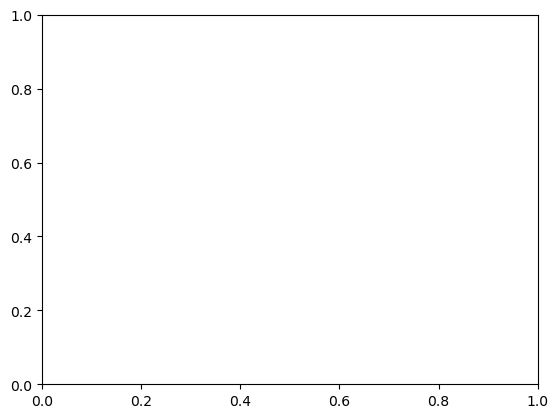

In [23]:
def plot_line(ax, theta, label, color, **kwargs):
    #theta[:2] /= np.linalg.norm(theta[:2], 2) ## probably get rid of this
    a = -theta[0] / theta[1]
    #yy = a * xx - theta[2] / theta[1]
    yy = a * xx
    ax.plot(xx, yy, label=label, c=color, **kwargs)

fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

#mins = np.argsort(np.sum(w_cv, axis=1), axis=0)[:50]
#print(np.sum(w_cv, axis=1)[mins])
#ax.scatter(*X[mins].T, c="black", linewidths=10)

#plot_line(ax, [*clf.coef_[0], clf.intercept_[0]], "sklearn", "plum")
#plot_line(ax, w, f"SmoothHinge ($\sigma$={sigma})", "purple")
plot_line(ax, w_og, f"FGD", "green")

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
ax.legend()

#ws = 1.45 # 1.75
#hs = 1.35 # 1.25
#fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
#plt.savefig('smoothhinge_comp.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

#median_w = np.median(np.abs(w_cv_og), axis=0)
median_w = np.median(w_cv_og, axis=0)
#median_w /= np.linalg.norm(median_w, 2)
plot_line(ax, median_w, "IACV median", "black", linestyle='--')

#mean_w = np.mean(np.abs(w_cv_og), axis=0)
mean_w = np.mean(w_cv_og, axis=0)
#mean_w /= np.linalg.norm(mean_w, 2)
plot_line(ax, mean_w, "IACV mean", "purple")

#w_true_mean = np.mean(np.abs(w_true_og), axis=0)
w_true_mean = np.mean(w_true_og, axis=0)
w_true_mean /= np.linalg.norm(w_true_mean, 2)

plot_line(ax, w_true_mean, f"True CV Mean", "blue")
plot_line(ax, w_og, f"SmoothHinge", "green")

plot_line(ax, [*clf.coef_[0], clf.intercept_[0]], "sklearn", "red", alpha=0.8)

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
fig.legend()

#ws = 1.45 # 1.75
#hs = 1.35 # 1.25
#fig.set_size_inches(w=5.73/ws, h=3.5/hs)
plt.tight_layout()
plt.show()
#plt.savefig('smoothhinge_stats.pgf', bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
ax.scatter(*X.T, c=y, cmap=plt.cm.bwr, linewidths=3)

t_percentile = 85
l_percentile = 100 - t_percentile
top_w = np.asarray([np.percentile(w_cv_og[:, i], t_percentile) for i in range(w_cv_og.shape[1])])
#top_w = np.abs(top_w)
#top_w /= np.linalg.norm(top_w, 2)
print(top_w)
plot_line(ax, top_w, f"{t_percentile}th Percentile", "black", linestyle='--')

bottom_w = np.asarray([np.percentile(w_cv_og[:, i], l_percentile) for i in range(w_cv_og.shape[1])])
#bottom_w = np.abs(bottom_w)
#bottom_w /= np.linalg.norm(bottom_w, 2)
print(bottom_w)
plot_line(ax, bottom_w, f"{l_percentile}th Percentile", "black")

#mid_p = (np.abs(bottom_w) + np.abs(top_w))/2
#mid_p = (bottom_w + top_w)/2
#print(mid_p)
#mid_p /= np.linalg.norm(mid_p, 2)
#plot_line(ax, median_w, "Median", "plum")
plot_line(ax, mean_w, "Mean", "plum")

ax.set_xlim(np.min(X[:, 0]), np.max(X[:, 0]))
ax.set_ylim(np.min(X[:, 1]), np.max(X[:, 1]))
ax.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
plt.scatter(X[:, 0], X[:, 1], c=np.sum(w_cv_og, axis=1))
plt.colorbar()
plt.plot()
plt.tight_layout()
#plt.savefig('smoothhinge_colorbar.png', dpi=400, bbox_inches='tight', pad_inches=0)

In [ ]:
fig, ax = plt.subplots()
xx = np.linspace(np.min(X[:, 0]), np.max(X[:, 0]))
plt.scatter(X[:, 0], X[:, 1], c=np.sum(w_true_og, axis=1))
plt.colorbar()
plt.plot()
plt.tight_layout()
#plt.savefig('smoothhinge_colorbar.png', dpi=400, bbox_inches='tight', pad_inches=0)